In [1]:
%reset -sf

import tensorflow as tf
import tf_keras
print("Tensorflow:", tf.__version__)
import tensorflow_probability as tfp
print("Tensorflow Probability:", tfp.__version__)

# GPU(s) setups
gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        
        # Enable memory growth for the first GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        
        # Instead of enabling memory growth, set a memory limit
        # memory_limit = 16_376 / 2 # Set the memory limit in MB
        memory_limit = -1
        if memory_limit >= 0:
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)]
            )
            
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

2025-02-28 10:32:48.082142: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-28 10:32:48.104483: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow: 2.16.1
Tensorflow Probability: 0.24.0
1 Physical GPUs, 1 Logical GPU


2025-02-28 10:32:49.329392: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [2]:
import sys
import os
import glob

HOME_PATH = os.path.abspath("..")
sys.path.insert(0, HOME_PATH + "/qe")

import paper_plot as pp

plot = pp.Plotter()

import pandas as pd
import numpy as np
import scipy as sp
import ROOT
from ROOT import TLorentzVector, TVector3
import multiprocessing
WORKERS = 16

from matplotlib import pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # suppress tensorflow imformation messages

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


SEED = 42  # set random seed (global variable)
GEV = 1e-3

In [3]:
import full_data as data

# reco
lead_lep = data.Lead_lep()
sublead_lep = data.Sublead_lep()
met = data.Met()

# truth
truth_lead_lep = data.Truth_lead_lep()
truth_sublead_lep = data.Truth_sublead_lep()
Truth_dilep = data.Truth_dilep()
truth_met = data.Truth_met()

# target Ws
w_lead = data.Lead_w()
w_sublead = data.Sublead_w()
mc_weight = data.MC_weight()

['/CGLMP', '/RecoLep0', '/RecoLep1', '/RecoMET', '/TruthCandLep0', '/TruthCandLep1', '/TruthCandMET', '/TruthHiggs', '/TruthLep0', '/TruthLep1', '/TruthLepN', '/TruthLepP', '/TruthNu0', '/TruthNu1', '/TruthNuN', '/TruthNuP', '/TruthW0', '/TruthW1', '/TruthWN', '/TruthWP', '/eventWeight', '/mcWeight', '/recoWeight', '/weight']


In [4]:
# define preselection cuts

cut_pre_pt_lead = lead_lep.pt > 22
print(len(lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = sublead_lep.pt > 15
print(len(lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.sqrt(
        np.square(lead_lep.energy + sublead_lep.energy)
        - np.square(lead_lep.px + sublead_lep.px)
        - np.square(lead_lep.py + sublead_lep.py)
        - np.square(lead_lep.pz + sublead_lep.pz)
    )
    > 10
)
print(len(lead_lep.energy) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = met.pt > 20
print(len(lead_lep.energy) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print(len(lead_lep.energy) - np.sum(PRE_CUT * 1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

# # define preselection cuts

# cut_pre_pt_lead = lead_lep.pt > -9999
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
# cut_pre_pt_sub = sublead_lep.pt > -9999
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
# cut_pre_dilep_m = (
#     np.sqrt(
#         np.square(lead_lep.energy + sublead_lep.energy)
#         - np.square(lead_lep.px + sublead_lep.px)
#         - np.square(lead_lep.py + sublead_lep.py)
#         - np.square(lead_lep.pz + sublead_lep.pz)
#     )
#     > -9999
# )
# print(len(lead_lep.energy) - np.sum(cut_pre_dilep_m * 1))
# cut_pre_pt_miss = met.pt > -9999
# print(len(lead_lep.energy) - np.sum(cut_pre_pt_miss * 1))
# PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
# print(len(lead_lep.energy) - np.sum(PRE_CUT * 1))
# del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)


0
29961
44269
89634
157782


In [5]:
# truth
truth_lead_lep_px = pd.DataFrame(truth_lead_lep.px[PRE_CUT])
truth_lead_lep_py = pd.DataFrame(truth_lead_lep.py[PRE_CUT])
truth_lead_lep_pz = pd.DataFrame(truth_lead_lep.pz[PRE_CUT])
truth_lead_lep_energy = pd.DataFrame(truth_lead_lep.energy[PRE_CUT])
truth_lead_lep_p4 = pd.concat(
	[truth_lead_lep_px, truth_lead_lep_py, truth_lead_lep_pz, truth_lead_lep_energy],
	axis=1,
).to_numpy()
truth_sublead_lep_px = pd.DataFrame(truth_sublead_lep.px[PRE_CUT])
truth_sublead_lep_py = pd.DataFrame(truth_sublead_lep.py[PRE_CUT])
truth_sublead_lep_pz = pd.DataFrame(truth_sublead_lep.pz[PRE_CUT])
truth_sublead_lep_energy = pd.DataFrame(truth_sublead_lep.energy[PRE_CUT])
truth_sublead_lep_p4 = pd.concat(
	[truth_sublead_lep_px, truth_sublead_lep_py, truth_sublead_lep_pz, truth_sublead_lep_energy],
	axis=1,
).to_numpy()
# reco
lead_lep_px = pd.DataFrame(lead_lep.px[PRE_CUT])
lead_lep_py = pd.DataFrame(lead_lep.py[PRE_CUT])
lead_lep_pz = pd.DataFrame(lead_lep.pz[PRE_CUT])
lead_lep_energy = pd.DataFrame(lead_lep.energy[PRE_CUT])
lead_lep_p4 = pd.concat(
	[lead_lep_px, lead_lep_py, lead_lep_pz, lead_lep_energy],
	axis=1,
).to_numpy()
sublead_lep_px = pd.DataFrame(sublead_lep.px[PRE_CUT])
sublead_lep_py = pd.DataFrame(sublead_lep.py[PRE_CUT])
sublead_lep_pz = pd.DataFrame(sublead_lep.pz[PRE_CUT])
sublead_lep_energy = pd.DataFrame(sublead_lep.energy[PRE_CUT])
sublead_lep_p4 = pd.concat(
	[sublead_lep_px, sublead_lep_py, sublead_lep_pz, sublead_lep_energy],
	axis=1,
).to_numpy()

In [6]:

## Observing variables

obs_kin = np.column_stack(
    (
        lead_lep.px,
        lead_lep.py,
        lead_lep.pz,
        lead_lep.energy,
        sublead_lep.px,
        sublead_lep.py,
        sublead_lep.pz,
        sublead_lep.energy,
        # np.log(sublead_lep.energy),
        # np.log(lead_lep.energy),
        # lead_lep.eta,
        # sublead_lep.eta,
        met.px,
        met.py,
    )
)[PRE_CUT]

# weights
mc_weight = mc_weight.w.to_numpy()[PRE_CUT]

# Kinematics of observing variables (inputs for training)
print("int_kin shape:", obs_kin.shape)
# print(print(obs_kin.describe()))
# obs_kin = obs_kin.to_numpy() # convert to numpy array

# ROBUST_OBS = RobustScaler()
# obs_kin = ROBUST_OBS.fit_transform(obs_kin)
# print(type(obs_kin))

int_kin shape: (851115, 10)


In [7]:
## Interesting variables

w_lead_px = pd.DataFrame(w_lead.px[PRE_CUT])
w_lead_py = pd.DataFrame(w_lead.py[PRE_CUT])
w_lead_pz = pd.DataFrame(w_lead.pz[PRE_CUT])
w_lead_e = pd.DataFrame(w_lead.energy[PRE_CUT])
w_lead_log_e = pd.DataFrame(np.log(w_lead_e))
w_lead_sqrt_e = pd.DataFrame(np.sqrt(w_lead_e))
w_sublead_px = pd.DataFrame(w_sublead.px[PRE_CUT])
w_sublead_py = pd.DataFrame(w_sublead.py[PRE_CUT])
w_sublead_pz = pd.DataFrame(w_sublead.pz[PRE_CUT])
w_sublead_e = pd.DataFrame(w_sublead.energy[PRE_CUT])
w_sublead_log_e = pd.DataFrame(np.log(w_sublead_e))
w_sublead_sqrt_e = pd.DataFrame(np.sqrt(w_sublead_e))
w_lead_m = pd.DataFrame(w_lead.m[PRE_CUT])
w_sublead_m = pd.DataFrame(w_sublead.m[PRE_CUT])

# Kinematics of interesting variables (target for training)
int_kin = np.concatenate(
    [
        w_lead_px,
        w_lead_py,
        w_lead_pz,
        w_lead_e,
        w_sublead_px,
        w_sublead_py,
        w_sublead_pz,
        w_sublead_e,
        # np.square(w_lead_m) / np.mean(w_lead_m),
        # np.square(w_sublead_m) / np.mean(w_lead_m),
        w_lead_m,
        w_sublead_m,
    ],
    axis=-1,
)
print("int_kin shape:", int_kin.shape)
# int_kin = int_kin.to_numpy()  # convert to numpy array
print(type(int_kin))

int_kin shape: (851115, 10)
<class 'numpy.ndarray'>


In [8]:
# Train test split

indices_arr = np.arange(int_kin.shape[0], dtype="int")
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.8,
    test_size=0.2,
    random_state=SEED,
    shuffle=True,
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=SEED
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
valid_x = obs_kin[valid_indices]
# test_x = np.concatenate([test_x, valid_x], axis=0)

train_y = int_kin[train_indices]
test_y = int_kin[test_indices]
valid_y = int_kin[valid_indices]
# test_y = np.concatenate([test_y, valid_y], axis=0)

print("Total evts:", len(indices_arr))
print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)

Total evts: 851115
X (Interest)
Training data shape: (680892, 10);
Validing data shape: (85111, 10);
Testing data shape: (85112, 10).
Y (Observed)
Training data shape: (680892, 10);
Validing data shape: (85111, 10);
Testing data shape: (85112, 10).


In [9]:
# training variables
BATCH_SIZE = 512
EPOCHS = 1024
LEARNING_RATE = 1e-5

# create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(train_x, tf.float32), 
    tf.cast(train_y, tf.float32)
)).cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(valid_x, tf.float32), 
    tf.cast(valid_y, tf.float32)
)).cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [10]:
def mass_loss(x_batch, y_pred):
    _epsilon = 1e-10
    x_batch = tf.cast(x_batch, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    n0_4vect = y_pred[..., :4] - x_batch[..., :4]
    n1_4vect = y_pred[..., 4:8] - x_batch[..., 4:8]

    nu0_mass = tf.sqrt(
        tf.math.maximum(
            tf.abs(tf.square(n0_4vect[..., 3]) - 
                    tf.reduce_sum(tf.square(n0_4vect[..., :3]), axis=-1)), _epsilon
        )
    )
    nu1_mass = tf.sqrt(
        tf.math.maximum(
            tf.abs(tf.square(n1_4vect[..., 3]) - 
                    tf.reduce_sum(tf.square(n1_4vect[..., :3]), axis=-1)), _epsilon
        )
    )
    
    return tf.reduce_mean(nu0_mass + nu1_mass)

def dinu_pt_loss(x_batch, y_pred):
    _epsilon = 1e-10
    x_batch = tf.cast(x_batch, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    n0_4vect = y_pred[..., :4] - x_batch[..., :4]
    n1_4vect = y_pred[..., 4:8] - x_batch[..., 4:8]
    
    nn_4vect = n0_4vect + n1_4vect
    nn_px = nn_4vect[..., 0]
    nn_py = nn_4vect[..., 1]
    
    nn_px_diff = tf.math.maximum(tf.abs(nn_px - x_batch[..., 8]), _epsilon)
    nn_py_diff = tf.math.maximum(tf.abs(nn_py - x_batch[..., 9]), _epsilon)
    
    return tf.reduce_mean(nn_px_diff + nn_py_diff)

def w_mass_loss(y_pred):
    _epsilon = 1e-10
    y_pred = tf.cast(y_pred, tf.float32)
    
    w0_4Vect = y_pred[..., :4]
    w1_4Vect = y_pred[..., 4:8]
    
    w0_mass = tf.sqrt(
        tf.math.maximum(
            tf.abs(tf.square(w0_4Vect[..., 3]) - 
                    tf.reduce_sum(tf.square(w0_4Vect[..., :3]), axis=-1)), _epsilon
        )
    )
    w1_mass = tf.sqrt(
        tf.math.maximum(
            tf.abs(tf.square(w1_4Vect[..., 3]) - 
                    tf.reduce_sum(tf.square(w1_4Vect[..., :3]), axis=-1)), _epsilon
        )
    )
    
    shape = tf.shape(w0_mass)
    random_numbers = tf.random.uniform(shape=shape, minval=0, maxval=1)
    onshell = tf.where(random_numbers <= 0.82, w0_mass, w1_mass)

    return tf.reduce_mean(tf.abs(onshell - 80.0)) + _epsilon

def higgs_mass_loss(y_pred):
    _epsilon = 1e-10
    y_pred = tf.cast(y_pred, tf.float32)
    
    w0_4Vect = y_pred[..., :4]
    w1_4Vect = y_pred[..., 4:8]
    higgs_4Vect = w0_4Vect + w1_4Vect
    
    higgs_mass = tf.sqrt(
        tf.math.maximum(
            tf.abs(tf.square(higgs_4Vect[..., 3]) - 
                    tf.reduce_sum(tf.square(higgs_4Vect[..., :3]), axis=-1)), _epsilon
        )
    )
    
    return tf.reduce_mean(tf.abs(higgs_mass - 125.0)) + _epsilon

def mse_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.reduce_mean(tf.keras.losses.mae(y_true, y_pred))

def mmd_loss(y_true, y_pred, bandwidth=5.0):
    # Extract the last 2 dimensions
    _epsilon = 1e-10
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    
    w0_4Vect = y_pred[..., :4]
    w1_4Vect = y_pred[..., 4:8]
    
    w0_mass = tf.sqrt(
        tf.math.maximum(
            tf.abs(tf.square(w0_4Vect[..., 3]) - 
                    tf.reduce_sum(tf.square(w0_4Vect[..., :3]), axis=-1)), _epsilon
        )
    )
    w1_mass = tf.sqrt(
        tf.math.maximum(
            tf.abs(tf.square(w1_4Vect[..., 3]) - 
                    tf.reduce_sum(tf.square(w1_4Vect[..., :3]), axis=-1)), _epsilon
        )
    )
    
    # Stack masses correctly to maintain batch dimension
    pred_m = tf.stack([w0_mass, w1_mass], axis=-1)  # Shape: [batch_size, 2]
    true_m = y_true[..., -2:]  # Shape: [batch_size, 2]
    
    # Calculate squared norms
    x_sq = tf.reduce_sum(tf.square(true_m), axis=1, keepdims=True)
    y_sq = tf.reduce_sum(tf.square(pred_m), axis=1, keepdims=True)
    
    # Calculate pairwise distances using kernel trick: ||x-y||^2 = ||x||^2 + ||y||^2 - 2*x^T*y
    dist_xx = x_sq - 2 * tf.matmul(true_m, true_m, transpose_b=True) + tf.transpose(x_sq)
    dist_yy = y_sq - 2 * tf.matmul(pred_m, pred_m, transpose_b=True) + tf.transpose(y_sq)
    dist_xy = x_sq - 2 * tf.matmul(true_m, pred_m, transpose_b=True) + tf.transpose(y_sq)
    
    # Apply RBF kernel
    kernel_xx = tf.exp(-dist_xx / (2 * bandwidth**2))
    kernel_yy = tf.exp(-dist_yy / (2 * bandwidth**2))
    kernel_xy = tf.exp(-dist_xy / (2 * bandwidth**2))
    
    # Calculate MMD
    mmd_value = tf.reduce_mean(kernel_xx) + tf.reduce_mean(kernel_yy) - 2 * tf.reduce_mean(kernel_xy)
    
    return mmd_value

In [11]:
import tensorflow as tf

class CustomModel(tf.keras.Model):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.current_epoch = tf.Variable(0.0, trainable=False)
        
        # Initialize metrics dictionary
        self.metric_dict = {
            'loss': tf.keras.metrics.Mean(name='loss'),
            'mass_loss': tf.keras.metrics.Mean(name='mass_loss'),
            'w_mass_loss': tf.keras.metrics.Mean(name='w_mass_loss'),
            'mmd_loss': tf.keras.metrics.Mean(name='mmd_loss'),
            'higgs_mass_loss': tf.keras.metrics.Mean(name='higgs_mass_loss'),
            'mse_loss': tf.keras.metrics.Mean(name='mse_loss'),
            'dinu_pt_loss': tf.keras.metrics.Mean(name='dinu_pt_loss')
        }

    def call(self, inputs, training=None):
        return self.base_model(inputs, training=training)
    
    def compile(self, optimizer, loss_weights=None, **kwargs):
        super().compile(optimizer=optimizer, **kwargs)
        default_weights = {
            'mse': 1.0,
            'mass': 1.0,
            'w_mass': 1.0,
            'mmd_loss': 1.0,
            'higgs_mass': 1.0,
            'dinu_pt': 1.0
        }
        self.loss_weights = {**default_weights, **(loss_weights or {})}

    @property
    def metrics(self):
        return list(self.metric_dict.values())

    def _compute_losses(self, x, y, predictions):
        epoch_factor = tf.math.maximum(
            tf.math.log(tf.cast(self.current_epoch + 21.0, tf.float32)) - 3.0,
            0.000001  # Ensure non-zero scaling
        )
        losses = {
            'mse': mse_loss(y, predictions),
            'mass':  mass_loss(x, predictions),
            'w_mass': w_mass_loss(predictions),
            'mmd': mmd_loss(y, predictions),
            'higgs_mass': higgs_mass_loss(predictions),
            'dinu_pt': dinu_pt_loss(x, predictions)
        }
        
        # Compute weighted sum of losses with safe handling
        _losses_factored = {
            'mse': mse_loss(y, predictions),
            'mass': epoch_factor * mass_loss(x, predictions),
            'w_mass': w_mass_loss(predictions),
            'mmd': 5*mmd_loss(y, predictions),
            'higgs_mass': higgs_mass_loss(predictions),
            'dinu_pt': dinu_pt_loss(x, predictions)
        }
        total_loss = tf.math.add_n(
            [self.loss_weights[name] * loss for name, loss in _losses_factored.items()]
        )
        
        return total_loss, losses

    def _update_metrics(self, total_loss, losses):
        """Helper method to update metrics"""
        loss_tracker = self.metric_dict['loss']
        loss_tracker.update_state(total_loss)
        
        for name, loss in losses.items():
            self.metric_dict[f'{name}_loss'].update_state(loss)

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            predictions = self(x, training=True)
            total_loss, losses = self._compute_losses(x, y, predictions)

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        self._update_metrics(total_loss, losses)
        
        return {name: metric.result() for name, metric in self.metric_dict.items()}

    def test_step(self, data):
        x, y = data
        predictions = self(x, training=False)
        total_loss, losses = self._compute_losses(x, y, predictions)
        
        self._update_metrics(total_loss, losses)
        
        return {name: metric.result() for name, metric in self.metric_dict.items()}

In [12]:
def dense_dropout_block(x, units, activation="swish", dropout_rate=0.0, l2=0.0):
    x = tf.keras.layers.Dense(
        units=units,
        use_bias=True,
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.L2(l2),
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    if dropout_rate > 0:    
        x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    return x

def residual_block(x, units, activation="swish", dropout_rate=0.0, l2=0.0):
    y = dense_dropout_block(x, units, activation=activation, dropout_rate=dropout_rate, l2=l2)
    y = dense_dropout_block(y, units, activation=activation, dropout_rate=dropout_rate, l2=l2)
    if x.shape[-1] != units:
        x = tf.keras.layers.Dense(units, activation=None, use_bias=False)(x)
    z = tf.keras.layers.Add()([x, y]) 
    z = tf.keras.layers.BatchNormalization()(z) 
    z = tf.keras.layers.Activation(activation)(z)
    return z

def build_model(input_shape):
    inputs = tf.keras.layers.Input(shape=(input_shape,), dtype=tf.float32)
    x = inputs

    # Stack residual blocks
    for _ in range(2):
        x = residual_block(x, 512, dropout_rate=0.2, l2=0.0)
        x = residual_block(x, 256, dropout_rate=0.0, l2=1e-6)
    for _ in range(1):
        # x = residual_block(x, 1024, dropout_rate =0.4, l2=0.0)
        x = residual_block(x, 512, dropout_rate=0.4, l2=0.0)
    for _ in range(2):
        x = residual_block(x, 256, dropout_rate=0.2, l2=0.0)
        x = residual_block(x, 128 , dropout_rate=0.0, l2=1e-6)

    # Bottleneck
    x = tf.keras.layers.Dense(32, activation=None, kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("swish")(x)
    
    outputs = tf.keras.layers.Dense(units=10, activation="linear", kernel_initializer='he_normal')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [13]:
# # Add TensorBoard import at the top with other imports
# from datetime import datetime

# # In the callbacks section:
# current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
# log_dir = f"{HOME_PATH}/10th_trial/logs/{current_time}"

# Build and compile model
base_model = build_model(train_x.shape[-1])
model = CustomModel(base_model)
model.summary()

# Model compilation with weights dictionary
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_weights={
        'mse': 30.0,
        'mass': 1.8,
        'w_mass': 2.5,
        'mmd': 2.5,
        'higgs_mass': 0.0,
        'dinu_pt': 0.0
    },
    jit_compile=True,
    steps_per_execution=256,
)

# Updated callbacks
class EpochUpdater(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.model.current_epoch.assign(float(epoch))

class DebugLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        current_epoch = self.model.current_epoch.numpy()
        test_log_term = tf.math.log(tf.cast(current_epoch + 21.0, tf.float32)) - 3.0
        print(f"Epoch {current_epoch}; Log factor: {test_log_term:.4f}; Mass loss: {logs['mass_loss']:.4f}")

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    EpochUpdater(),
    DebugLogger(),
    # tf.keras.callbacks.TensorBoard(
    #     log_dir=log_dir,
    #     histogram_freq=1,
    #     write_graph=True,
    #     write_images=True,
    #     update_freq='epoch',
    #     profile_batch=0,
    #     embeddings_freq=0,
    # ),
]

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=2,
)

# Print the weights
print("\nModel Loss Weights:")
for name, weight in model.loss_weights.items():
    print(f"{name:12s}: {weight:.3f}")

Model: "custom_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 10)             │     2,642,922 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,642,922 (10.08 MB)

 Trainable params: 2,625,962 (10.02 MB)

 Non-trainable params: 16,960 (66.25 KB)

Epoch 1/1024
Epoch 0.0; Log factor: 0.0445; Mass loss: 14.9826
1330/1330 - 44s - 33ms/step - dinu_pt_loss: 64.3881 - higgs_mass_loss: 123.4508 - loss: 2167.1221 - mass_loss: 14.9826 - mmd_loss: 1.0348 - mse_loss: 65.2008 - val_dinu_pt_loss: 64.0602 - val_higgs_mass_loss: 123.4236 - val_loss: 2160.8354 - val_mass_loss: 14.0333 - val_mmd_loss: 1.1174 - val_mse_loss: 64.9530 - val_w_mass_loss: 78.8642 - w_mass_loss: 78.7843
Epoch 2/1024
Epoch 1.0; Log factor: 0.0910; Mass loss: 22.8762
1330/1330 - 9s - 6ms/step - dinu_pt_loss: 63.7680 - higgs_mass_loss: 120.9615 - loss: 2153.5852 - mass_loss: 22.8762 - mmd_loss: 0.9374 - mse_loss: 64.8409 - val_dinu_pt_loss: 63.2583 - val_higgs_mass_loss: 120.0700 - val_loss: 2139.7327 - val_mass_loss: 24.0413 - val_mmd_loss: 0.9107 - val_mse_loss: 64.4279 - val_w_mass_loss: 76.6350 - w_mass_loss: 77.1573
Epoch 3/1024
Epoch 2.0; Log factor: 0.1355; Mass loss: 25.8960
1330/1330 - 9s - 7ms/step - dinu_pt_loss: 62.3213 - higgs_mass_loss: 119.0541 - loss: 214

I0000 00:00:1740738781.045246  379138 service.cc:145] XLA service 0x7b3dd8014750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740738781.045268  379138 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-02-28 10:33:01.261405: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1740738781.656714  379138 random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform_1/RandomUniform
2025-02-28 10:33:02.080718: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1740738785.809557  379928 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_13

In [14]:
# Make a directory
dir_name = HOME_PATH + "/10th_trial/ww_resregressor_result/"
savedmodel_path = dir_name + "saved_model"
name = "ww_resregressor"

# If the directory exists
if os.path.exists(dir_name):
    test_files = glob.glob(dir_name + "*" + name + "*")
    if test_files:
        for file in test_files:
            os.remove(file)
        print(f"Directory {dir_name} cleaned.")
    print(f"Directory {dir_name} exists.")
else:
    os.makedirs(dir_name)
    print(f"Directory {dir_name} created.")

# save modela
model.save(dir_name + name + ".keras", save_format="keras", overwrite=True)
tf.saved_model.save(model, savedmodel_path) # save model in saved_model format --> use in the onnx 

# predict
pred_y = model.predict(test_x)
# save predicted results
np.savez_compressed(dir_name + name + "_data.npz", pred_y=pred_y, test_y=test_y)
sig_pred = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth = np.load(dir_name + name + "_data.npz")["test_y"]

Directory /root/work/QE-mls/10th_trial/ww_resregressor_result/ cleaned.
Directory /root/work/QE-mls/10th_trial/ww_resregressor_result/ exists.
INFO:tensorflow:Assets written to: /root/work/QE-mls/10th_trial/ww_resregressor_result/saved_model/assets


INFO:tensorflow:Assets written to: /root/work/QE-mls/10th_trial/ww_resregressor_result/saved_model/assets


2660/2660 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


I0000 00:00:1740741556.821807  487182 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1740741556.848549  487174 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1740741556.941162  487165 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1740741557.066776  487189 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6', 8 bytes spill stores, 8 bytes spill loads

2025-02-28 11:19:18.291949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
I0000 00:00:1740741560.002207  487334 asm_compiler.cc:369] ptxas warning : Registers are 

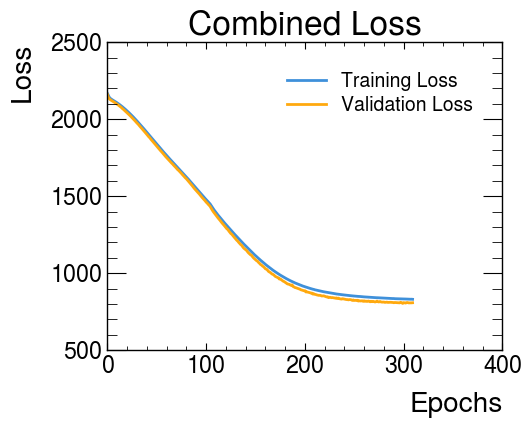

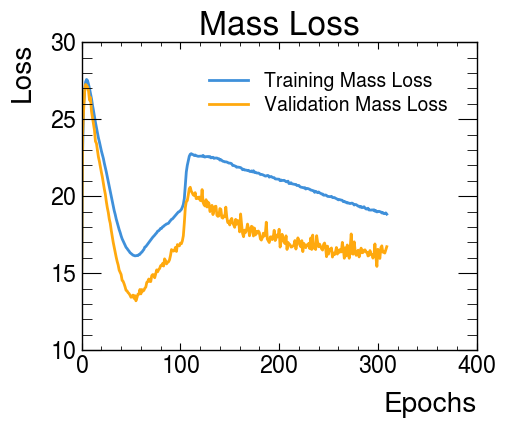

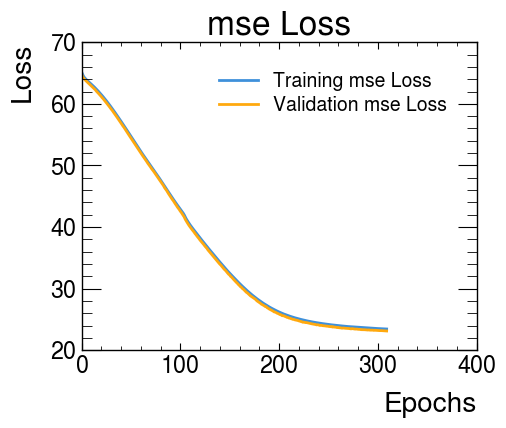

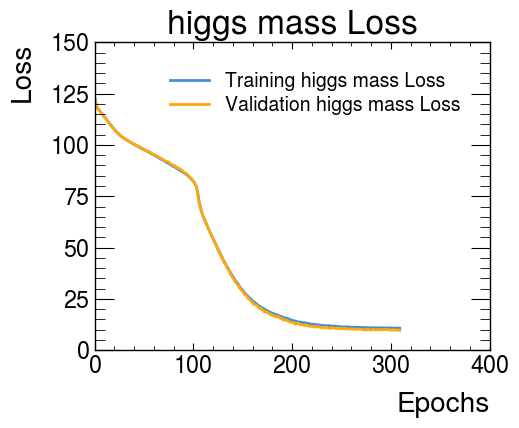

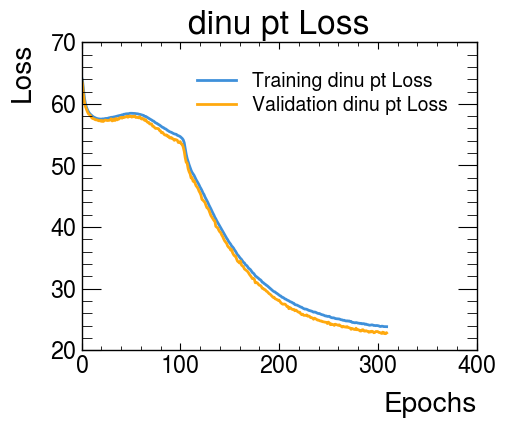

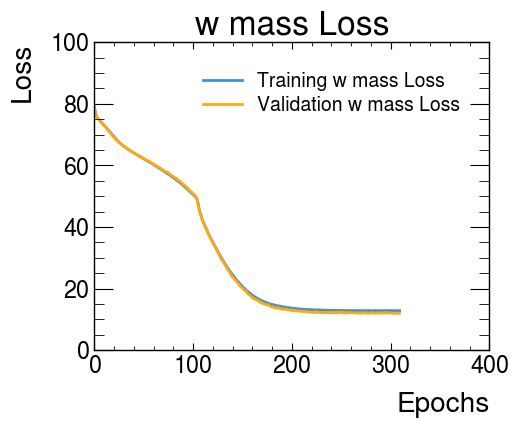

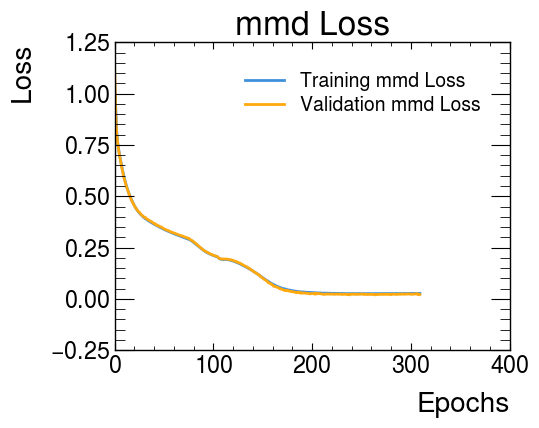

In [15]:
# Extract loss values
loss = history.history["loss"]
val_loss = history.history["val_loss"]
mass_loss = history.history["mass_loss"]
val_mass_loss = history.history["val_mass_loss"]
mse_loss = history.history["mse_loss"]
val_mse_loss = history.history["val_mse_loss"]
w_mass_loss = history.history["w_mass_loss"]
val_w_mass_loss = history.history["val_w_mass_loss"]
higgs_mass_loss = history.history["higgs_mass_loss"]
val_higgs_mass_loss = history.history["val_higgs_mass_loss"]
dinu_pt_loss = history.history["dinu_pt_loss"]
val_dinu_pt_loss = history.history["val_dinu_pt_loss"]
mmd_loss = history.history["mmd_loss"]
val_mmd_loss = history.history["val_mmd_loss"]


# 1) Plot combined training and validation loss
plt.figure(figsize=(5, 4))
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
# plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Combined Loss")
plt.legend()
plt.grid(False)
plt.show()

# 2) Plot mass training and validation loss
plt.figure(figsize=(5, 4))
plt.plot(mass_loss, label="Training Mass Loss")
plt.plot(val_mass_loss, label="Validation Mass Loss")
# plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Mass Loss")
plt.legend()
plt.grid(False)
plt.show()

# 3) Plot mse training and validation loss
plt.figure(figsize=(5, 4))
plt.plot(mse_loss, label="Training mse Loss")
plt.plot(val_mse_loss, label="Validation mse Loss")
# plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("mse Loss")
plt.legend()
plt.grid(False)
plt.show()

# 4) Plot higgs mass training and validation loss
plt.figure(figsize=(5, 4))
plt.plot(higgs_mass_loss, label="Training higgs mass Loss")
plt.plot(val_higgs_mass_loss, label="Validation higgs mass Loss")
# plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("higgs mass Loss")
plt.legend()
plt.grid(False)
plt.show()

# 5) Plot dinu pt loss
plt.figure(figsize=(5, 4))
plt.plot(dinu_pt_loss, label="Training dinu pt Loss")
plt.plot(val_dinu_pt_loss, label="Validation dinu pt Loss")
# plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("dinu pt Loss")
plt.legend()
plt.grid(False)
plt.show()

# 6) Plot w mass loss
plt.figure(figsize=(5, 4))
plt.plot(w_mass_loss, label="Training w mass Loss")
plt.plot(val_w_mass_loss, label="Validation w mass Loss")
# plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("w mass Loss")
plt.legend()
plt.grid(False)
plt.show()

# 7) Plot mmd loss
plt.figure(figsize=(5, 4))
plt.plot(mmd_loss, label="Training mmd Loss")
plt.plot(val_mmd_loss, label="Validation mmd Loss")
# plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("mmd Loss")
plt.legend()
plt.grid(False)
plt.show()


In [16]:
# save predicted results
np.savez_compressed(
    dir_name + name + "_data.npz",
    pred_y=sig_pred.reshape(sig_truth.shape),
    test_y=sig_truth,
)
sig_pred_inv = np.load(dir_name + name + "_data.npz")["pred_y"]
sig_truth_inv = np.load(dir_name + name + "_data.npz")["test_y"]

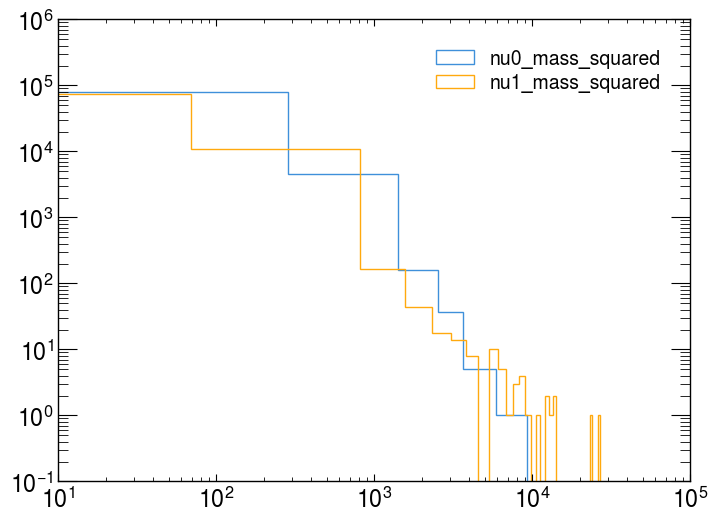

nu0_mass_squared avg: 59.70441394769746
nu1_mass_squared avg: 31.884147029202893


In [17]:
# neutrino mass checking
nu0_4vect = sig_pred_inv[:, :4] - test_x[:, :4]
nu1_4vect = sig_pred_inv[:, 4:8] - test_x[:, 4:8]
nu0_mass_squared = np.square(nu0_4vect[:, 3]) - np.square(nu0_4vect[:, 0]) - np.square(nu0_4vect[:, 1]) - np.square(nu0_4vect[:, 2])
nu1_mass_squared = np.square(nu1_4vect[:, 3]) - np.square(nu1_4vect[:, 0]) - np.square(nu1_4vect[:, 1]) - np.square(nu1_4vect[:, 2])
# nu0_mass_squared
plt.hist(nu0_mass_squared, bins=100, histtype="step", label="nu0_mass_squared")
plt.hist(nu1_mass_squared, bins=100, histtype="step", label="nu1_mass_squared")
plt.semilogx()
plt.semilogy()
plt.legend()
plt.show()

print("nu0_mass_squared avg:", np.mean(nu0_mass_squared))
print("nu1_mass_squared avg:", np.mean(nu1_mass_squared))
# plt.hist(nu1_mass_squared, bins=100, range=(0, 100), histtype="step", label="nu1_mass_squared")


True mean: 0.031, std: 39.544, min: -585.857, max: 803.254


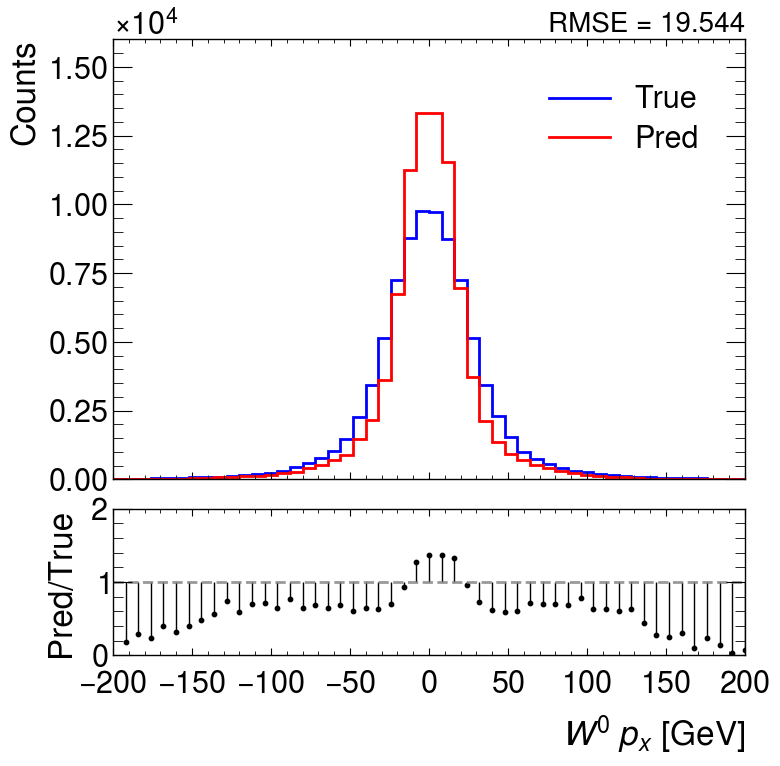

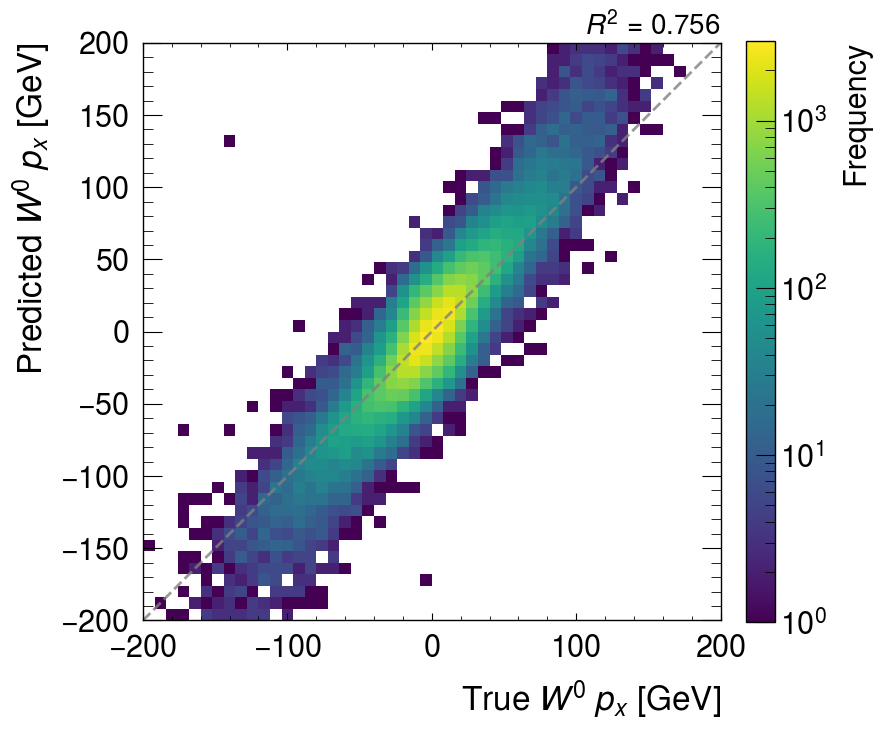

In [18]:
print(
    f"True mean: {np.mean(sig_truth_inv[:,0]):.3f}, std: {np.std(sig_truth_inv[:,0]):.3f}, min: {np.min(sig_truth_inv[:,0]):.3f}, max: {np.max(sig_truth_inv[:,0]):.3f}"
)

set_range = [-200, 200]

plot.hist_1d(
    sig_truth_inv[:,0], sig_pred_inv[:,0],
    title=f"RMSE = {np.sqrt(mean_squared_error(sig_truth_inv[:,0], sig_pred_inv[:,0], sample_weight=None)):.3f}",
    xlabel="$W^{0}\ p_{x}$ [GeV]",
    ranges=set_range
)

plot.hist_2d(
    sig_truth_inv[:,0], sig_pred_inv[:,0],
    title=r"$R^{2}$ = " + f"{r2_score(sig_truth_inv[:,0], sig_pred_inv[:,0]):.3f}",
    xlabel="True $W^{0}\ p_{x}$ [GeV]",
    ylabel="Predicted $W^{0}\ p_{x}$ [GeV]",
    ranges=set_range
)

True mean: -0.124, std: 27.801, min: -399.814, max: 373.865


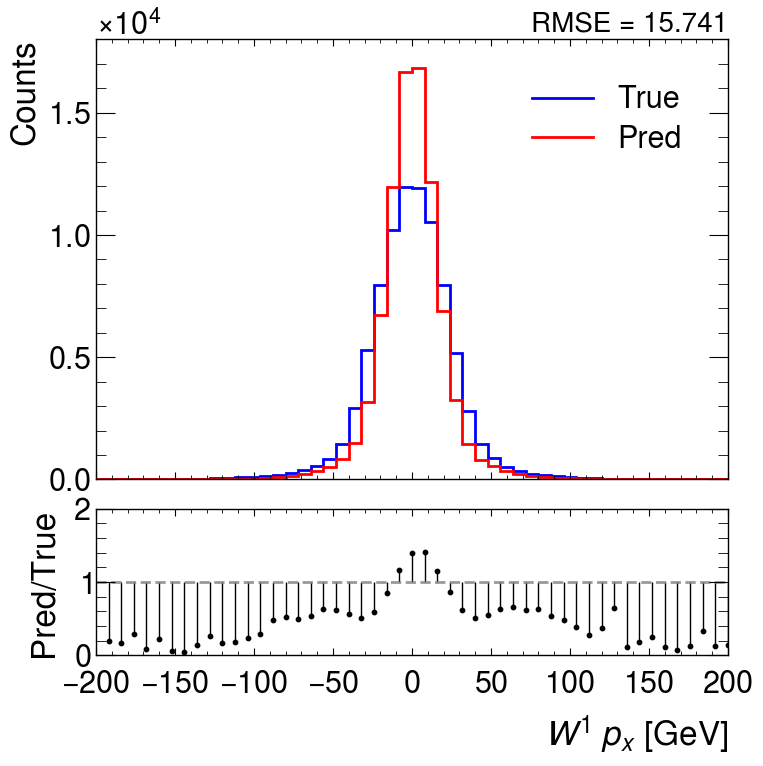

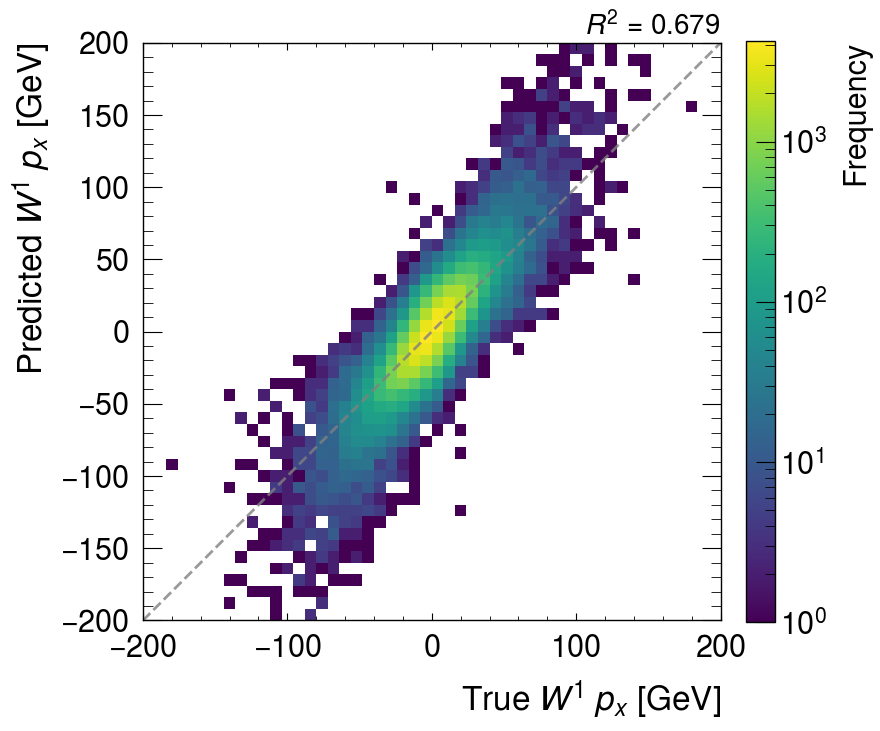

In [19]:
print(
    f"True mean: {np.mean(sig_truth_inv[:,4]):.3f}, std: {np.std(sig_truth_inv[:,4]):.3f}, min: {np.min(sig_truth_inv[:,4]):.3f}, max: {np.max(sig_truth_inv[:,4]):.3f}"
)

set_range = [-200, 200]


plot.hist_1d(
    sig_truth_inv[:,4], sig_pred_inv[:,4],
    title=f"RMSE = {np.sqrt(mean_squared_error(sig_truth_inv[:,4], sig_pred_inv[:,4], sample_weight=None)):.3f}",
    xlabel="$W^{1}\ p_{x}$ [GeV]",
    ranges=set_range
)

plot.hist_2d(
    sig_truth_inv[:,4], sig_pred_inv[:,4],
    title=r"$R^{2}$ = " + f"{r2_score(sig_truth_inv[:,4], sig_pred_inv[:,4]):.3f}",
    xlabel="True $W^{1}\ p_{x}$ [GeV]",
    ylabel="Predicted $W^{1}\ p_{x}$ [GeV]",
    ranges=set_range
)

True mean: -0.013, std: 39.620, min: -755.579, max: 609.143


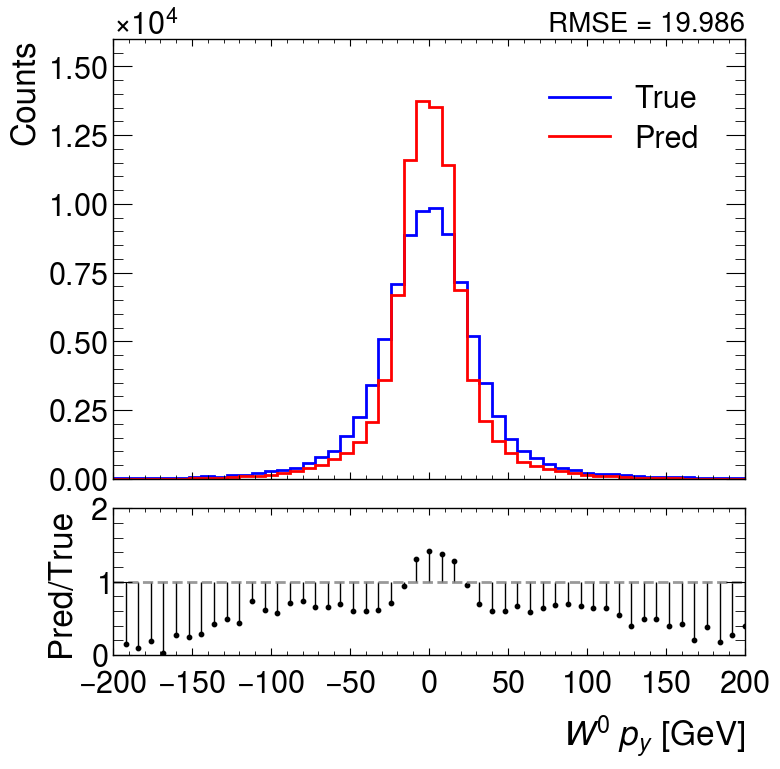

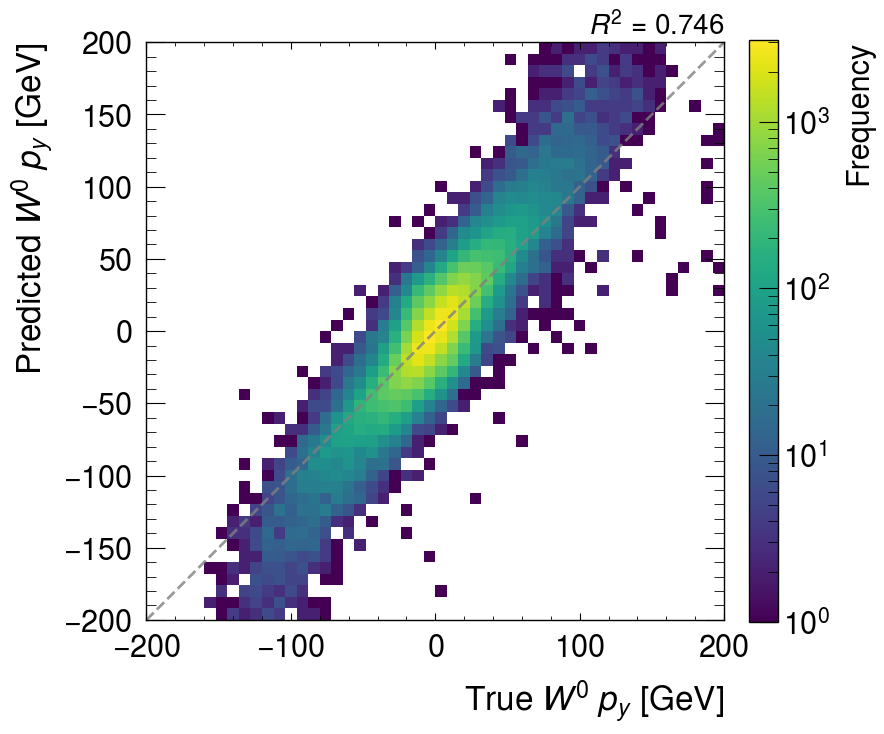

In [20]:
print(
    f"True mean: {np.mean(sig_truth_inv[:,1]):.3f}, std: {np.std(sig_truth_inv[:,1]):.3f}, min: {np.min(sig_truth_inv[:,1]):.3f}, max: {np.max(sig_truth_inv[:,1]):.3f}"
)

set_range = [-200, 200]

plot.hist_1d(
    sig_truth_inv[:,1], sig_pred_inv[:,1],
    title=f"RMSE = {np.sqrt(mean_squared_error(sig_truth_inv[:,1], sig_pred_inv[:,1], sample_weight=None)):.3f}",
    xlabel="$W^{0}\ p_{y}$ [GeV]",
    ranges=set_range
)

plot.hist_2d(
    sig_truth_inv[:,1], sig_pred_inv[:,1],
    title=r"$R^{2}$ = " + f"{r2_score(sig_truth_inv[:,1], sig_pred_inv[:,1]):.3f}",
    xlabel="True $W^{0}\ p_{y}$ [GeV]",
    ylabel="Predicted $W^{0}\ p_{y}$ [GeV]",
    ranges=set_range
)

True mean: 0.031, std: 27.968, min: -417.838, max: 580.447


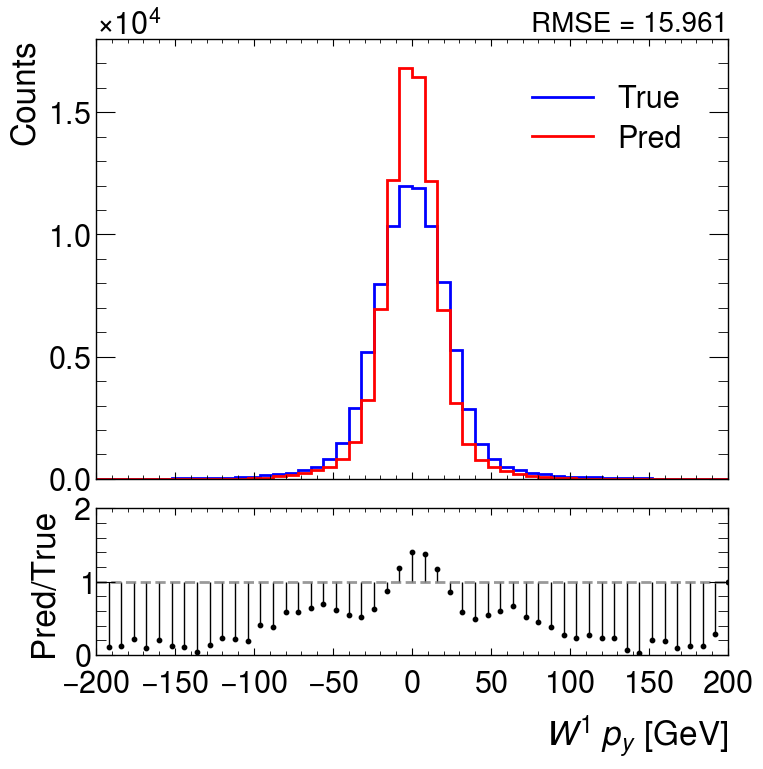

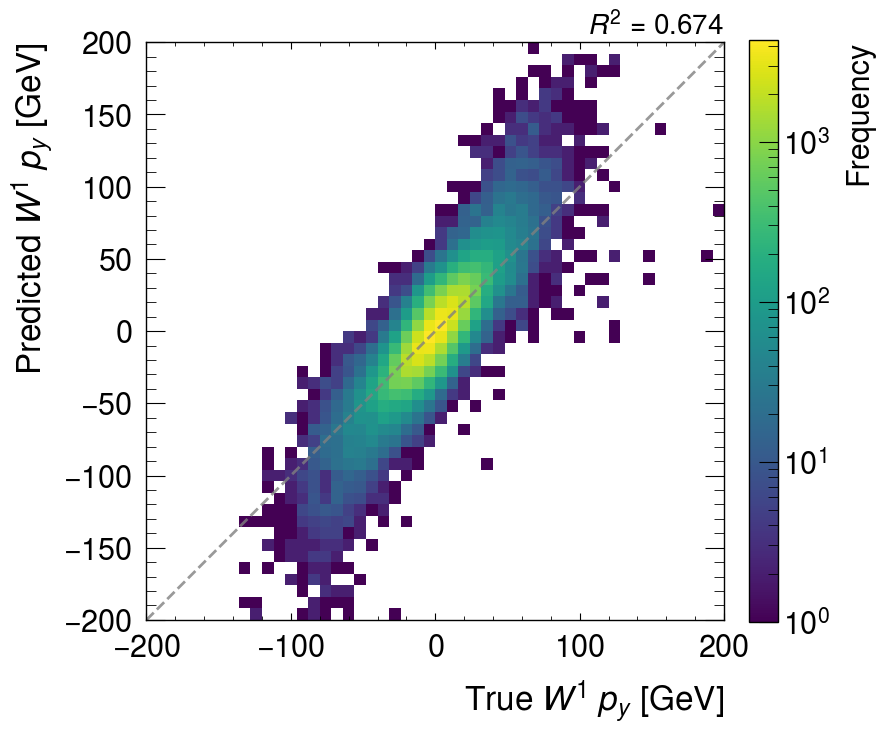

In [21]:
print(
    f"True mean: {np.mean(sig_truth_inv[:,5]):.3f}, std: {np.std(sig_truth_inv[:,5]):.3f}, min: {np.min(sig_truth_inv[:,5]):.3f}, max: {np.max(sig_truth_inv[:,5]):.3f}"
)

set_range = [-200, 200]

plot.hist_1d(
    sig_truth_inv[:,5], sig_pred_inv[:,5],
    title=f"RMSE = {np.sqrt(mean_squared_error(sig_truth_inv[:,5], sig_pred_inv[:,5], sample_weight=None)):.3f}",
    xlabel="$W^{1}\ p_{y}$ [GeV]",
    ranges=set_range
)

plot.hist_2d(
    sig_truth_inv[:,5], sig_pred_inv[:,5],
    title=r"$R^{2}$ = " + f"{r2_score(sig_truth_inv[:,5], sig_pred_inv[:,5]):.3f}",
    xlabel="True $W^{1}\ p_{y}$ [GeV]",
    ylabel="Predicted $W^{1}\ p_{y}$ [GeV]",
    ranges=set_range
)

True mean: 0.308, std: 170.752, min: -1446.473, max: 1754.351


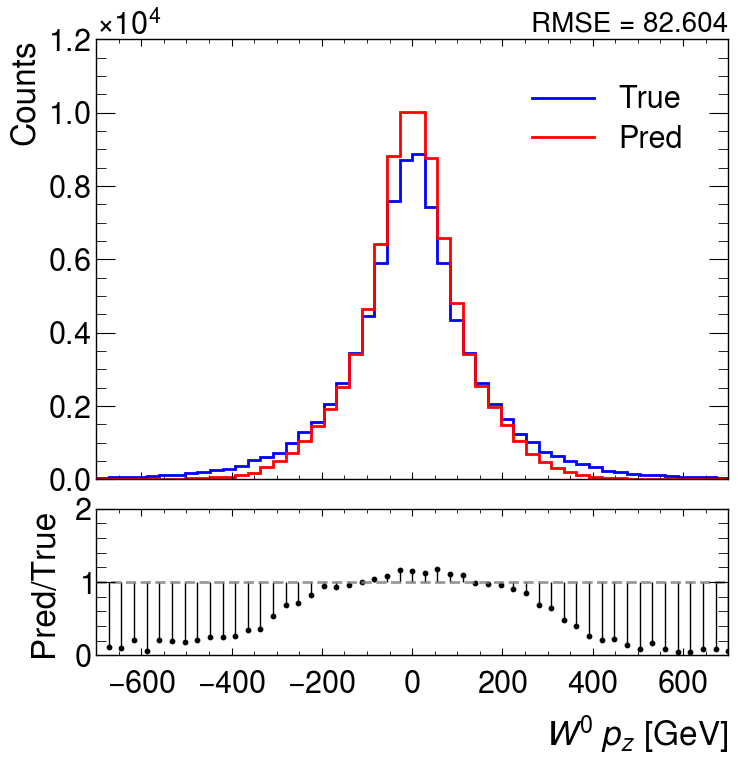

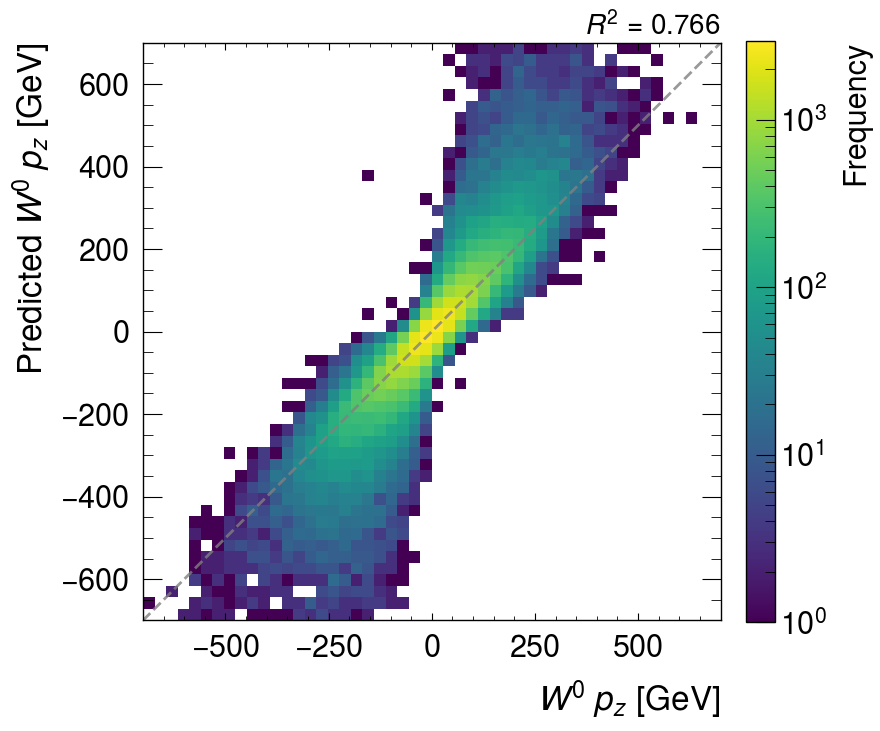

In [22]:
print(
    f"True mean: {np.mean(sig_truth_inv[:,2]):.3f}, std: {np.std(sig_truth_inv[:,2]):.3f}, min: {np.min(sig_truth_inv[:,2]):.3f}, max: {np.max(sig_truth_inv[:,2]):.3f}"
)

set_range = [-700, 700]

plot.hist_1d(
    sig_truth_inv[:,2], sig_pred_inv[:,2],
    title=f"RMSE = {np.sqrt(mean_squared_error(sig_truth_inv[:,2], sig_pred_inv[:,2], sample_weight=None)):.3f}",
    xlabel="$W^{0}\ p_{z}$ [GeV]",
    ranges=set_range
)

plot.hist_2d(
    sig_truth_inv[:,2], sig_pred_inv[:,2],
    title=r"$R^{2}$ = " + f"{r2_score(sig_truth_inv[:,2], sig_pred_inv[:,2]):.3f}",
    xlabel="$W^{0}\ p_{z}$ [GeV]",
    ylabel="Predicted $W^{0}\ p_{z}$ [GeV]",
    ranges=set_range
)

Truth mean: -0.337, std: 110.947, min: -1170.774, max: 1427.069


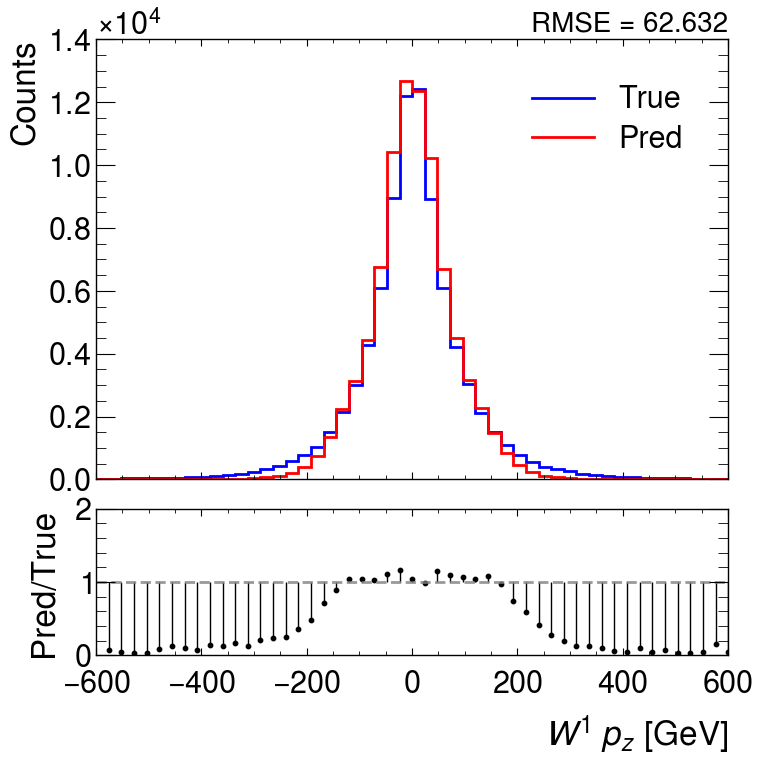

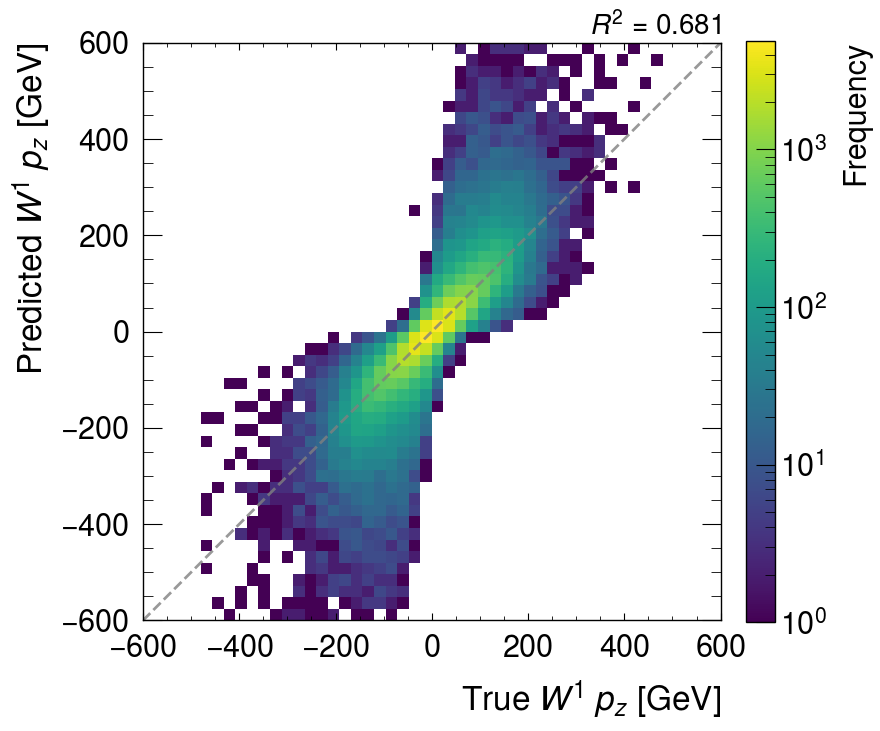

In [23]:
print(
    f"Truth mean: {np.mean(sig_truth_inv[:,6]):.3f}, std: {np.std(sig_truth_inv[:,6]):.3f}, min: {np.min(sig_truth_inv[:,6]):.3f}, max: {np.max(sig_truth_inv[:,6]):.3f}"
)

set_range = [-600, 600]

plot.hist_1d(
    sig_truth_inv[:,6], sig_pred_inv[:,6],
    title=f"RMSE = {np.sqrt(mean_squared_error(sig_truth_inv[:,6], sig_pred_inv[:,6], sample_weight=None)):.3f}",
    xlabel="$W^{1}\ p_{z}$ [GeV]",
    ranges=set_range
)

plot.hist_2d(
    sig_truth_inv[:,6], sig_pred_inv[:,6],
    title=r"$R^{2}$ = " + f"{r2_score(sig_truth_inv[:,6], sig_pred_inv[:,6]):.3f}",
    xlabel="True $W^{1}\ p_{z}$ [GeV]",
    ylabel="Predicted $W^{1}\ p_{z}$ [GeV]",
    ranges=set_range
)

True mean: 158.446, std: 111.648, min: 21.707, max: 1791.292


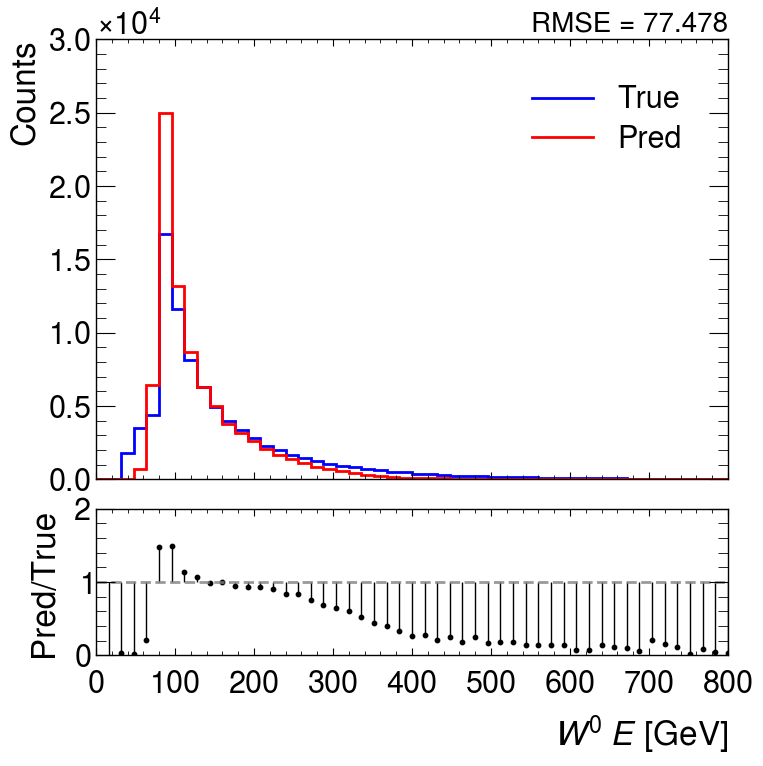

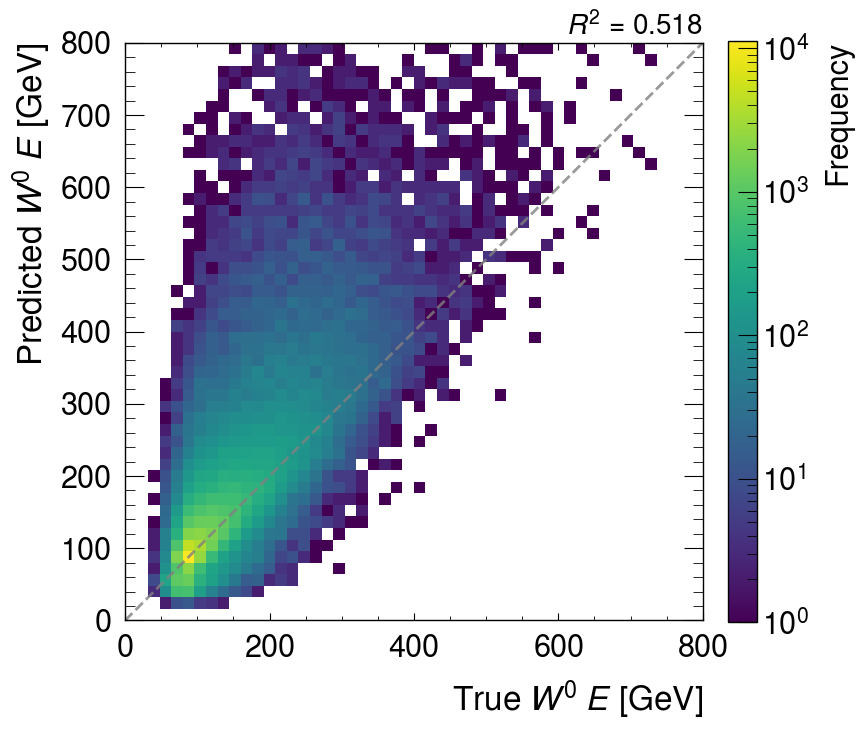

In [24]:
print(
    f"True mean: {np.mean(sig_truth_inv[:,3]):.3f}, std: {np.std(sig_truth_inv[:,3]):.3f}, min: {np.min(sig_truth_inv[:,3]):.3f}, max: {np.max(sig_truth_inv[:,3]):.3f}"
)

set_range = [0, 800]

plot.hist_1d(
    sig_truth_inv[:,3], sig_pred_inv[:,3],
    title=f"RMSE = {np.sqrt(mean_squared_error(sig_truth_inv[:,3], sig_pred_inv[:,3], sample_weight=None)):.3f}",
    xlabel="$W^{0}\ E$ [GeV]",
    ranges=set_range
)

plot.hist_2d(
    sig_truth_inv[:,3], sig_pred_inv[:,3],
    title=r"$R^{2}$ = " + f"{r2_score(sig_truth_inv[:,3], sig_pred_inv[:,3]):.3f}",
    xlabel="True $W^{0}\ E$ [GeV]",
    ylabel="Predicted $W^{0}\ E$ [GeV]",
    ranges=set_range
)

True mean: 98.991, std: 77.608, min: 17.001, max: 1443.825


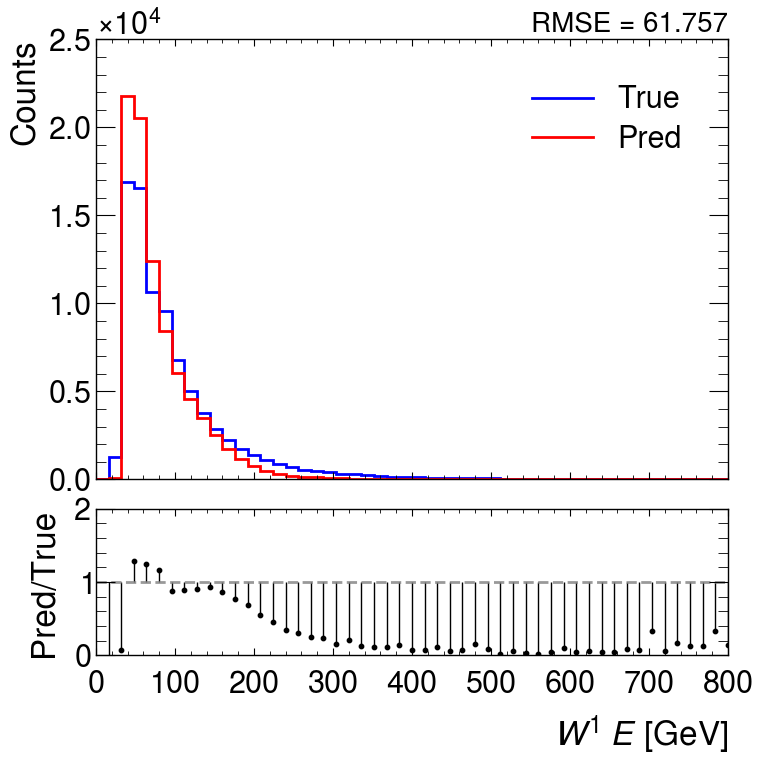

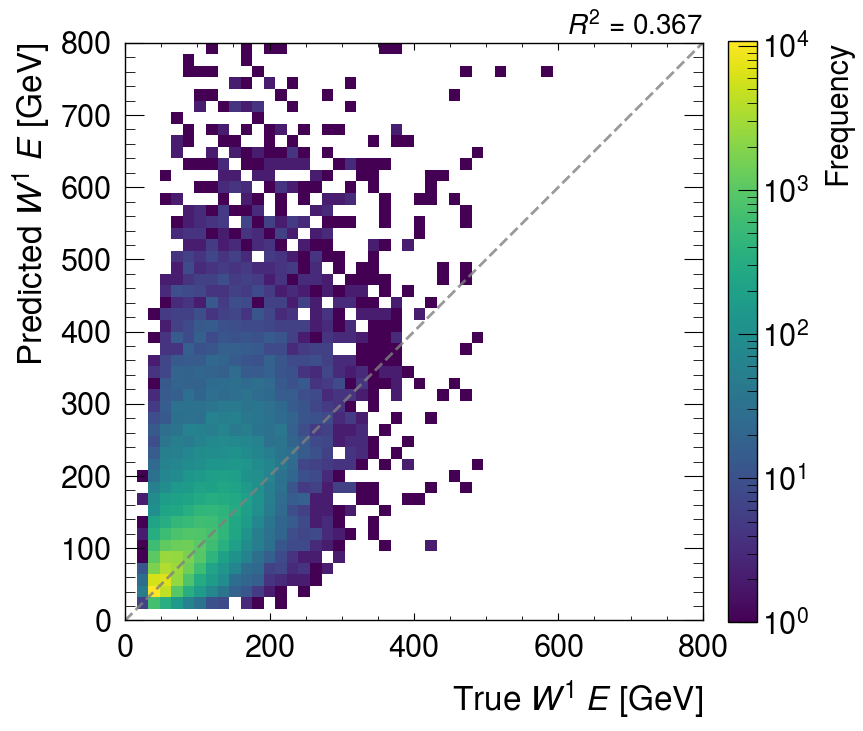

In [25]:
print(
    f"True mean: {np.mean(sig_truth_inv[:,7]):.3f}, std: {np.std(sig_truth_inv[:,7]):.3f}, min: {np.min(sig_truth_inv[:,7]):.3f}, max: {np.max(sig_truth_inv[:,7]):.3f}"
)

set_range = [0, 800]

plot.hist_1d(
    sig_truth_inv[:,7], sig_pred_inv[:,7],
    title=f"RMSE = {np.sqrt(mean_squared_error(sig_truth_inv[:,7], sig_pred_inv[:,7], sample_weight=None)):.3f}",
    xlabel="$W^{1}\ E$ [GeV]",
    ranges=set_range
)

plot.hist_2d(
    sig_truth_inv[:,7], sig_pred_inv[:,7],
    title=r"$R^{2}$ = " + f"{r2_score(sig_truth_inv[:,7], sig_pred_inv[:,7]):.3f}",
    xlabel="True $W^{1}\ E$ [GeV]",
    ylabel="Predicted $W^{1}\ E$ [GeV]",
    ranges=set_range
)

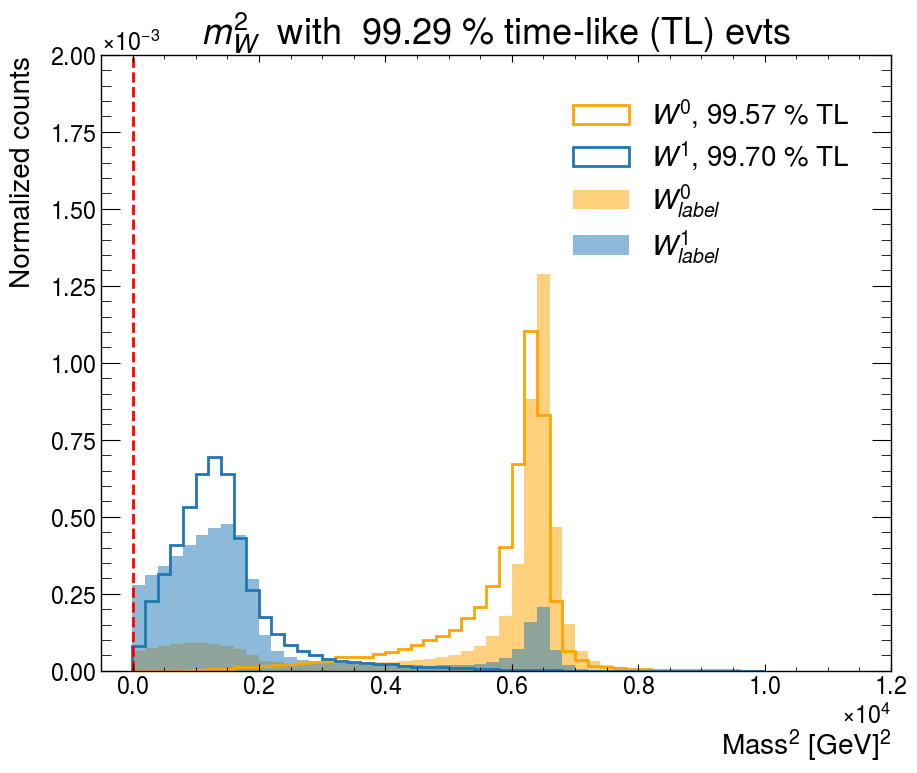

In [26]:
lead_time_like = np.square(sig_pred_inv[:, 3]) - np.sum(
    np.square(sig_pred_inv[:, 0:3]), axis=1
)
lead_time_mask = (lead_time_like > 0) * 1
sublead_time_like = np.square(sig_pred_inv[:, 7]) - np.sum(
    np.square(sig_pred_inv[:, 4:7]), axis=1
)
sublead_time_mask = (sublead_time_like > 0) * 1

bin_edges = np.linspace(-5, 1.0e4, 51)
figure = plt.figure(figsize=(10, 8))
plt.hist(
    lead_time_like,
    bins=bin_edges,
    fill=False,
    color="orange",
    histtype="step",
    label=r"$W^{0}$, "
    + f"{100 * np.sum(lead_time_mask) / len(lead_time_mask):.2f} % TL",
    density=True,
    weights=None,
    linewidth=2,
)
plt.hist(
    sublead_time_like,
    bins=bin_edges,
    fill=False,
    color="tab:blue",
    histtype="step",
    label=r"$W^{1}$, "
    + f"{100 * np.sum(sublead_time_mask) / len(sublead_time_mask):.2f} % TL",
    density=True,
    weights=None,
    linewidth=2,
)
plt.hist(
    np.square(w_lead.m),
    bins=bin_edges,
    color="orange",
    fill=True,
    histtype="bar",
    alpha=0.5,
    label=r"$W_{label}^{0}$",
    density=True,
    # weights=mc_weight,
)
plt.hist(
    np.square(w_sublead.m),
    bins=bin_edges,
    color="tab:blue",
    fill=True,
    histtype="bar",
    alpha=0.5,
    label=r"$W_{label}^{1}$",
    density=True,
    # weights=mc_weight,
)
plt.vlines(0, 0, 2e-3, color="red", linestyle="--")
plt.xlim(-5e2, 1.2e4)
plt.ylim(0, 2e-3)
plt.xlabel(r"Mass$^{2}$ [GeV]$^{2}$", labelpad=20)
plt.ylabel("Normalized counts")
plt.title(
    r"$m^{2}_{W}$ "
    + f" with {100 * np.sum(lead_time_mask * sublead_time_mask) / len(lead_time_mask): .2f} % time-like (TL) evts",
    fontsize=26,
    )
plt.legend(loc="upper right", prop={'size': 20})  # Adjust the size value as needed
plt.show()

Truth mean: 3615.291, std: 2594.373, min: 4.010, max: 11077.988


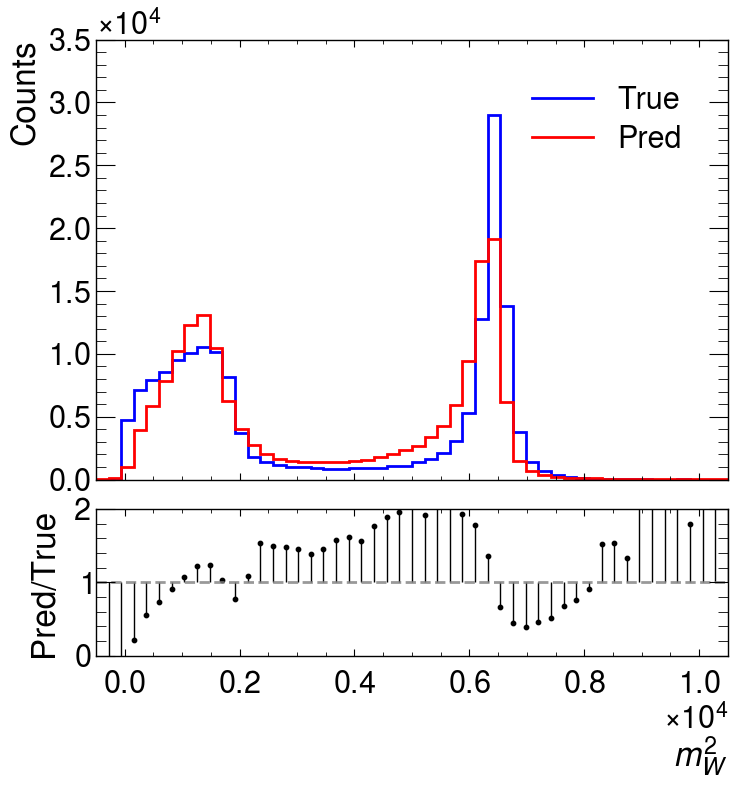

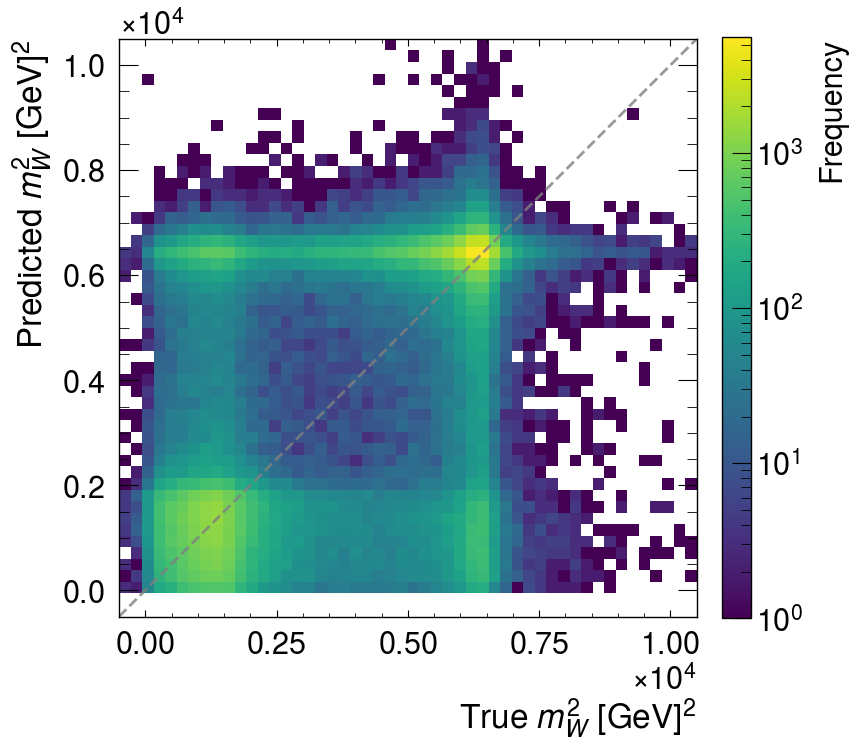

In [27]:
# TODO: 2d mass squared
pred_m2 = np.concatenate([lead_time_like, sublead_time_like], axis=-1)
truth_m2 = np.concatenate(
    [np.square(w_lead.m)[test_indices], np.square(w_sublead.m)[test_indices]], axis=-1
)

print(
    f"Truth mean: {np.mean(truth_m2):.3f}, std: {np.std(truth_m2):.3f}, min: {np.min(truth_m2):.3f}, max: {np.max(truth_m2):.3f}"
)

set_range = [-500, 10_500]


plot.hist_1d(
    truth_m2, pred_m2,
    title="",
    xlabel=r"$m_{W}^{2}$",
    xpad=25,
    ranges=set_range
)

plot.hist_2d(
    truth_m2, pred_m2,
    title="",
    xlabel="True $m_{W}^{2}$ [GeV]$^2$",
    ylabel="Predicted $m_{W}^{2}$ [GeV]$^2$",
    xpad=25,
    ranges=set_range
)

In [28]:

# TODO: CGLMP

def Bij(particles):
    # Ensure ROOT is properly initialized
    ROOT.gROOT.SetBatch(True)

    def cglmp(z_xp, z_xn, z_yp, z_yn):
        """
        This is a function to calculate Bij (CGLMP values).
        :param z_xp: Angle (xi) between positive lepton and x-axis.
        :param z_xn: Angle (xi) between negative lepton and x-axis.
        :param z_yp: Angle (xi) between positive lepton and y-axis.
        :param z_xn: Angle (xi) between negative lepton and y-axis.
        """
        # count expectation value, use (27) in Alan's paper
        tr_a = (np.divide(8, np.sqrt(3))) * (z_xp * z_xn + z_yp * z_yn)
        tr_b = (
            25
            * (np.square(z_xp) - np.square(z_yp))
            * (np.square(z_xn) - np.square(z_yn))
        )
        tr_c = 100 * (z_xp * z_yp * z_xn * z_yn)
        tr = tr_a + tr_b + tr_c

        return tr

    WpBoson = TLorentzVector(*particles[:4])
    WpLepton = TLorentzVector(*particles[4:8])
    WnBoson = TLorentzVector(*particles[8:12])
    WnLepton = TLorentzVector(*particles[12:16])

    # construct Higgs 4-vector
    Higgs = WpBoson + WnBoson

    # construct a moving orthogonal basis (k,r,n)
    Beam_p = TLorentzVector(0, 0, 1, 1)  # spatial-axis

    # define boost vector
    Higgsb = Higgs.BoostVector()

    # (1) performs a boost transformation from the rod frame to the rawal one.
    # Perform boost transformation from the rod frame to the rawal one
    for vec in [WpBoson, WpLepton, WnBoson, WnLepton, Beam_p]:
        vec.Boost(-Higgsb)

    # 2. Define (k,r,n) -> definitions are in Alan's paper
    k_per = TVector3(WpBoson.X(), WpBoson.Y(), WpBoson.Z())
    p_per = TVector3(Beam_p.X(), Beam_p.Y(), Beam_p.Z())  # in the Higgs rest frame
    k = k_per.Unit()  # normalized -> unit vector
    p = p_per.Unit()
    y = p.Dot(k)
    r_length = np.sqrt(1 - y * y)
    r = (1 / r_length) * (p - y * k)
    n = (1 / r_length) * (p.Cross(k))  # (1/sin)*sin = 1 -> unit vector

    # 3. Further boost to W+ and W- frame respectively
    WpkBoost = WpBoson.BoostVector()
    WpBoson.Boost(-WpkBoost)
    WpLepton.Boost(-WpkBoost)
    WnkBoost = WnBoson.BoostVector()
    WnBoson.Boost(-WnkBoost)
    WnLepton.Boost(-WnkBoost)

    # 4. Map all particle to (k,r,n) frame
    WpLp = WpLepton.Vect()  # momentum in (k,r,n)
    WnLp = WnLepton.Vect()
    # Mapping to n-r-k basis
    WpLp_k = TLorentzVector(WpLp.Dot(n), WpLp.Dot(r), WpLp.Dot(k), WpLepton.E())
    WnLp_k = TLorentzVector(WnLp.Dot(n), WnLp.Dot(r), WnLp.Dot(k), WnLepton.E())

    # 5. Calculate directional cosines
    # directional cosine from Wp
    WpLp_Vect_Mag = WpLp_k.Vect().Mag()
    cos_n_join_p = np.divide(WpLp_k.X(), WpLp_Vect_Mag)
    cos_r_join_p = np.divide(WpLp_k.Y(), WpLp_Vect_Mag)
    cos_k_join_p = np.divide(WpLp_k.Z(), WpLp_Vect_Mag)
    # directional cosine from Wn
    WnLp_Vect_Mag = WnLp_k.Vect().Mag()
    cos_n_join_n = np.divide(WnLp_k.X(), WnLp_Vect_Mag)
    cos_r_join_n = np.divide(WnLp_k.Y(), WnLp_Vect_Mag)
    cos_k_join_n = np.divide(WnLp_k.Z(), WnLp_Vect_Mag)

    # 6. Calculate Bij (CGLMP values)
    B_xy = cglmp(cos_n_join_p, cos_n_join_n, cos_r_join_p, cos_r_join_n)
    B_yz = cglmp(cos_r_join_p, cos_r_join_n, cos_k_join_p, cos_k_join_n)
    B_zx = cglmp(cos_n_join_p, cos_n_join_n, cos_k_join_p, cos_k_join_n)

    return (
        np.array([B_xy, B_yz, B_zx]),
        np.array([cos_n_join_p, cos_r_join_p, cos_k_join_p]),
        np.array([cos_n_join_n, cos_r_join_n, cos_k_join_n]),
    )
    
def result_generator(particles):
    with multiprocessing.Pool(WORKERS) as pool:
        # Retrieve the output from the pool
        results = list(pool.map(Bij, particles))
    
    # Unpack the results
    bij, xi_p, xi_n = zip(*results)
    
    bij = np.vstack(bij)  # Flatten the nested array
    xi_p = np.vstack(xi_p)
    xi_n = np.vstack(xi_n)
    mask = np.any(np.isnan(bij), axis=1)
    return (
        bij[~mask, :],
        xi_p[~mask, :],
        xi_n[~mask, :],
    )

In [29]:
# reco
particles = np.concatenate(
    [
        sig_pred_inv[:, 0:4],
        lead_lep_p4[test_indices],
        sig_pred_inv[:, 4:8],
        sublead_lep_p4[test_indices],
    ],
    axis=1,
)
bij = result_generator(particles)[0][0:80_000,:]
xi_p = result_generator(particles)[1][0:80_000,:]
xi_n = result_generator(particles)[2][0:80_000,:]

# truth
particles = np.concatenate(
    [
        sig_truth_inv[:, 0:4],
        truth_lead_lep_p4[test_indices],
        sig_truth_inv[:, 4:8],
        truth_sublead_lep_p4[test_indices],
    ],
    axis=1,
)
truth_bij = result_generator(particles)[0][0:80_000,:]
truth_xi_p = result_generator(particles)[1][0:80_000,:]
truth_xi_n = result_generator(particles)[2][0:80_000,:]

True mean     : 2.468, std: 12.019, min: -25.100, max: 29.607
Predicted mean: 3.273, std: 8.921, min: -24.929, max: 29.516


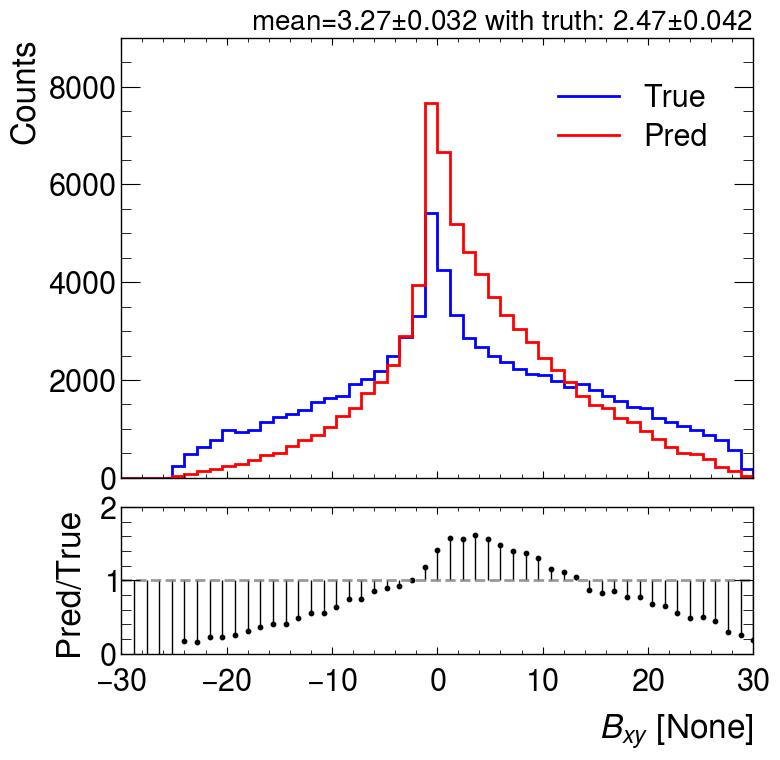

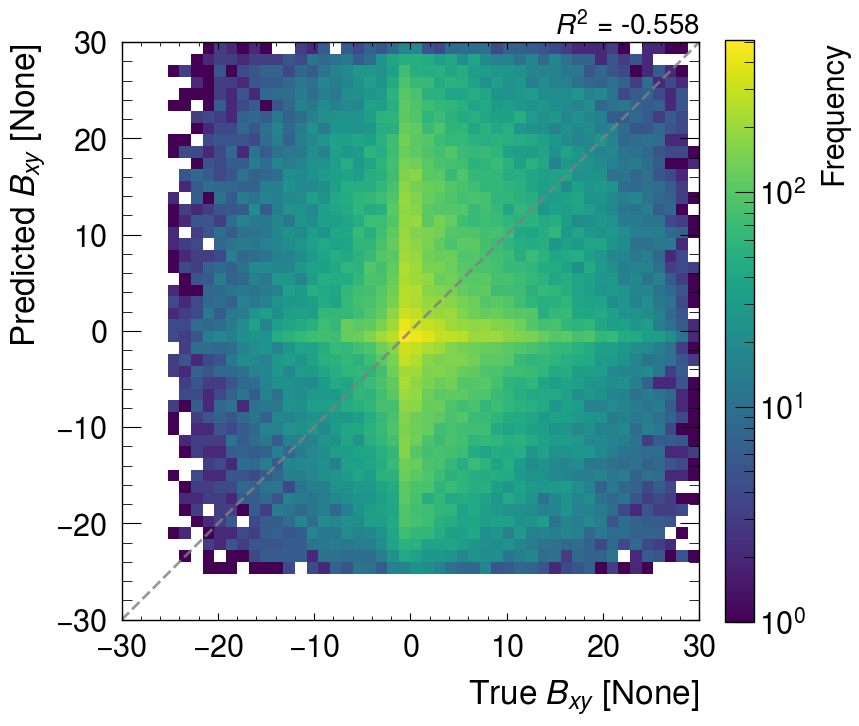

In [30]:

print(
    f"True mean     : {np.mean(truth_bij[:,0]):.3f}, std: {np.std(truth_bij[:,0]):.3f}, min: {np.min(truth_bij[:,0]):.3f}, max: {np.max(truth_bij[:,0]):.3f}"
)
print(
    f"Predicted mean: {np.mean(bij[:,0]):.3f}, std: {np.std(bij[:,0]):.3f}, min: {np.min(bij[:,0]):.3f}, max: {np.max(bij[:,0]):.3f}"
)

set_range = [-30, 30]

plot.hist_1d(
    truth_bij[:,0], bij[:,0],
    title=rf"mean={np.mean(bij[:,0]):.2f}$\pm${sp.stats.sem(bij[:,0]):.3f}"
    + f" with truth: {np.mean(truth_bij[:,0]):.2f}$\pm${sp.stats.sem(truth_bij[:,0]):.3f}",
    xlabel=r"$B_{xy}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_bij[:,0], bij[:,0],
    title=r"$R^{2}$ = " + f"{r2_score(truth_bij[:,0], bij[:,0]):.3f}",
    xlabel="True $B_{{xy}}$ [None]",
    ylabel="Predicted $B_{{xy}}$ [None]",
    ranges=set_range
)

True mean     : 2.060, std: 8.727, min: -25.095, max: 29.572
Predicted mean: 1.665, std: 8.404, min: -25.075, max: 29.610


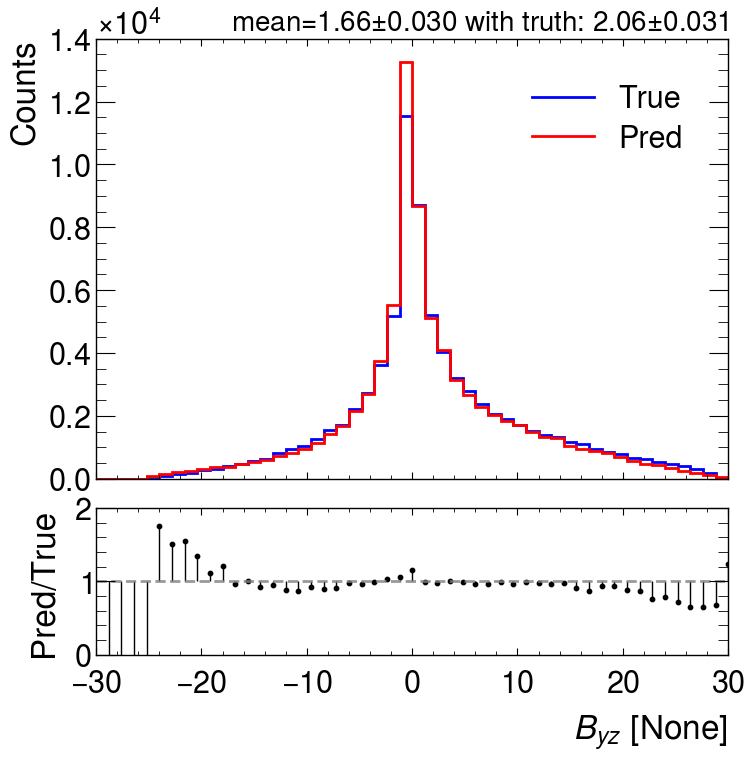

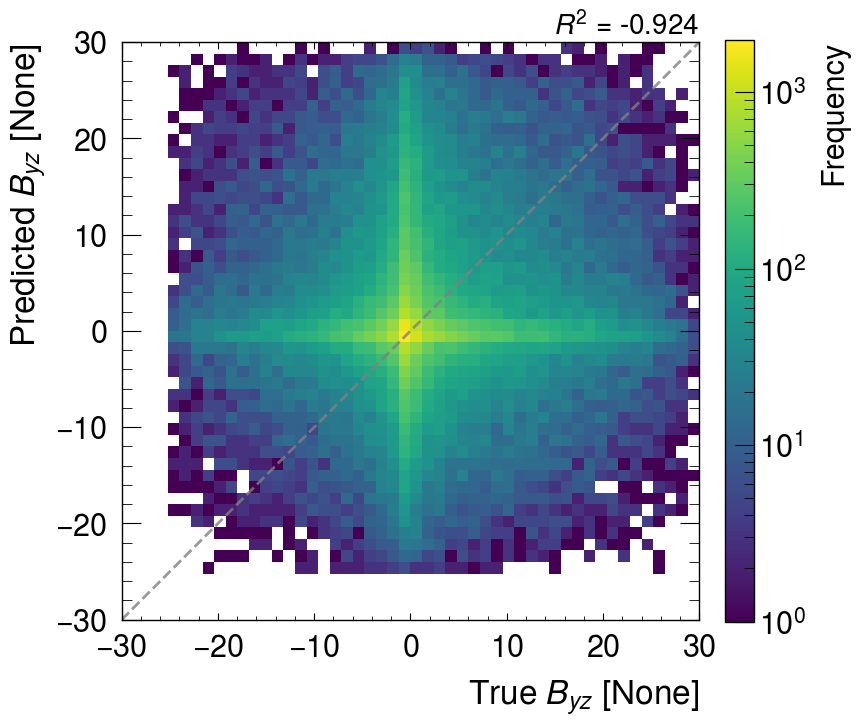

In [31]:

print(
    f"True mean     : {np.mean(truth_bij[:,1]):.3f}, std: {np.std(truth_bij[:,1]):.3f}, min: {np.min(truth_bij[:,1]):.3f}, max: {np.max(truth_bij[:,1]):.3f}"
)
print(
    f"Predicted mean: {np.mean(bij[:,1]):.3f}, std: {np.std(bij[:,1]):.3f}, min: {np.min(bij[:,1]):.3f}, max: {np.max(bij[:,1]):.3f}"
)

set_range = [-30, 30]


plot.hist_1d(
    truth_bij[:,1], bij[:,1],
    title=fr"mean={np.mean(bij[:,1]):.2f}$\pm${sp.stats.sem(bij[:,1]):.3f}"
    + f" with truth: {np.mean(truth_bij[:,1]):.2f}$\pm${sp.stats.sem(truth_bij[:,1]):.3f}",
    xlabel=r"$B_{yz}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_bij[:,1], bij[:,1],
    title=r"$R^{2}$ = " + f"{r2_score(truth_bij[:,1], bij[:,1]):.3f}",
    xlabel="True $B_{{yz}}$ [None]",
    ylabel="Predicted $B_{{yz}}$ [None]",
    ranges=set_range
)

True mean     : 3.228, std: 10.739, min: -25.073, max: 29.599
Predicted mean: 0.969, std: 12.691, min: -25.096, max: 29.422


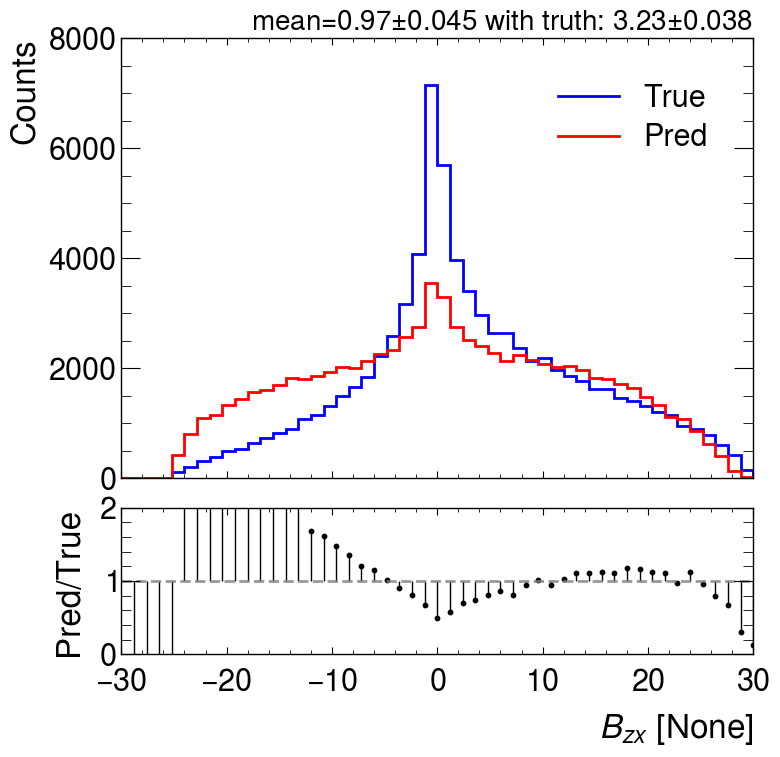

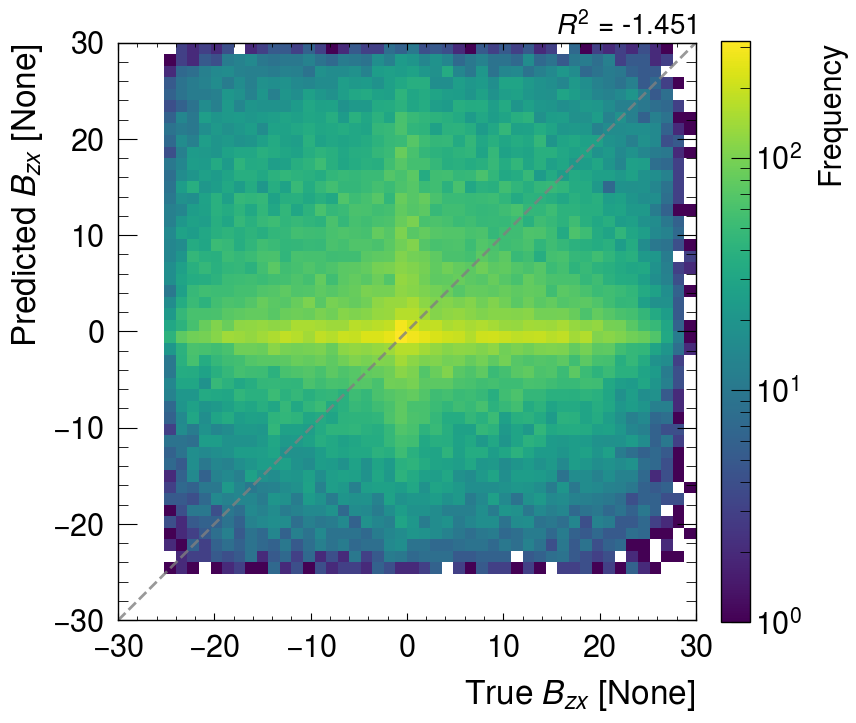

In [32]:

print(
    f"True mean     : {np.mean(truth_bij[:,2]):.3f}, std: {np.std(truth_bij[:,2]):.3f}, min: {np.min(truth_bij[:,2]):.3f}, max: {np.max(truth_bij[:,2]):.3f}"
)
print(
    f"Predicted mean: {np.mean(bij[:,2]):.3f}, std: {np.std(bij[:,2]):.3f}, min: {np.min(bij[:,2]):.3f}, max: {np.max(bij[:,2]):.3f}"
)

set_range = [-30, 30]

plot.hist_1d(
    truth_bij[:,2], bij[:,2],
    title=rf"mean={np.mean(bij[:,2]):.2f}$\pm${sp.stats.sem(bij[:,2]):.3f}"
    + f" with truth: {np.mean(truth_bij[:,2]):.2f}$\pm${sp.stats.sem(truth_bij[:,2]):.3f}",
    xlabel=r"$B_{zx}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_bij[:,2], bij[:,2],
    title=r"$R^{2}$ = " + f"{r2_score(truth_bij[:,2], bij[:,2]):.3f}",
    xlabel="True $B_{{zx}}$ [None]",
    ylabel="Predicted $B_{{zx}}$ [None]",
    ranges=set_range
)

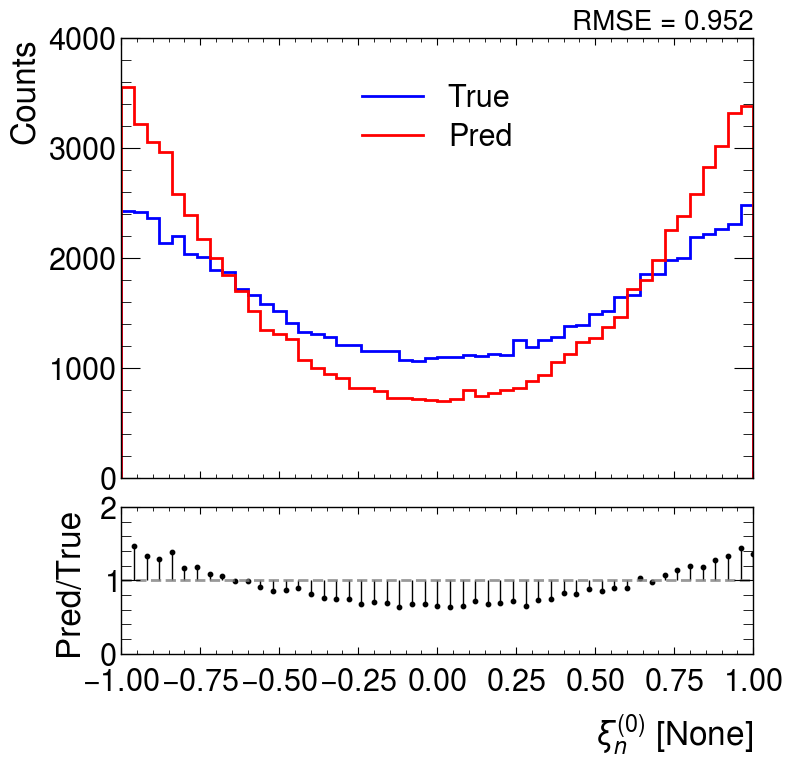

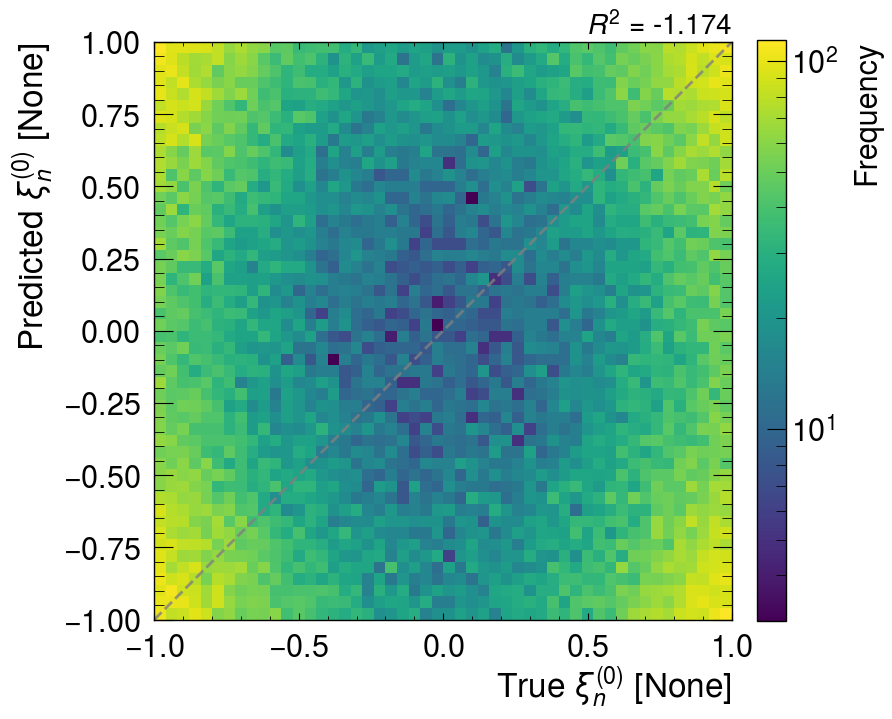

In [33]:
set_range = [-1, 1]


plot.hist_1d(
    truth_xi_p[:,0], xi_p[:,0],
    title=f"RMSE = {np.sqrt(mean_squared_error(truth_xi_p[:,0], xi_p[:,0], sample_weight=None)):.3f}",
    xlabel=r"$\xi^{(0)}_{n}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_xi_p[:,0], xi_p[:,0],
    title=r"$R^{2}$ = " + f"{r2_score(truth_xi_p[:,0], xi_p[:,0]):.3f}",
    xlabel=r"True $\xi^{(0)}_{n}$ [None]",
    ylabel=r"Predicted $\xi^{(0)}_{n}$ [None]",
    xpad=0,
    ranges=set_range
)

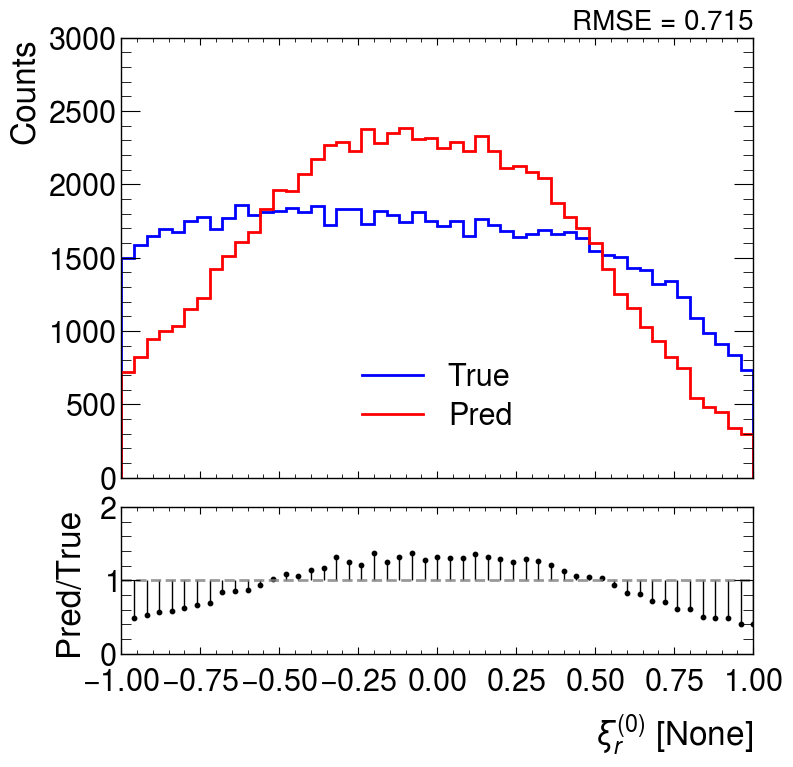

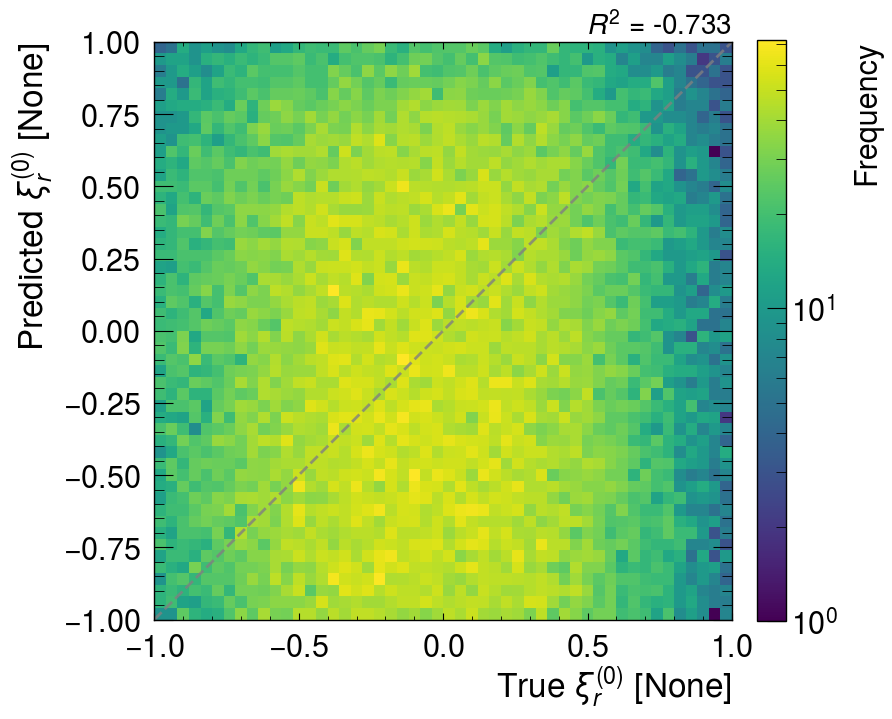

In [34]:
set_range = [-1, 1]

plot.hist_1d(
    truth_xi_p[:,1], xi_p[:,1],
    title=f"RMSE = {np.sqrt(mean_squared_error(truth_xi_p[:,1], xi_p[:,1], sample_weight=None)):.3f}",
    xlabel=r"$\xi^{(0)}_{r}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_xi_p[:,1], xi_p[:,1],
    title=r"$R^{2}$ = " + f"{r2_score(truth_xi_p[:,1], xi_p[:,1]):.3f}",
    xlabel=r"True $\xi^{(0)}_{r}$ [None]",
    ylabel=r"Predicted $\xi^{(0)}_{r}$ [None]",
    xpad=0,
    ranges=set_range
)

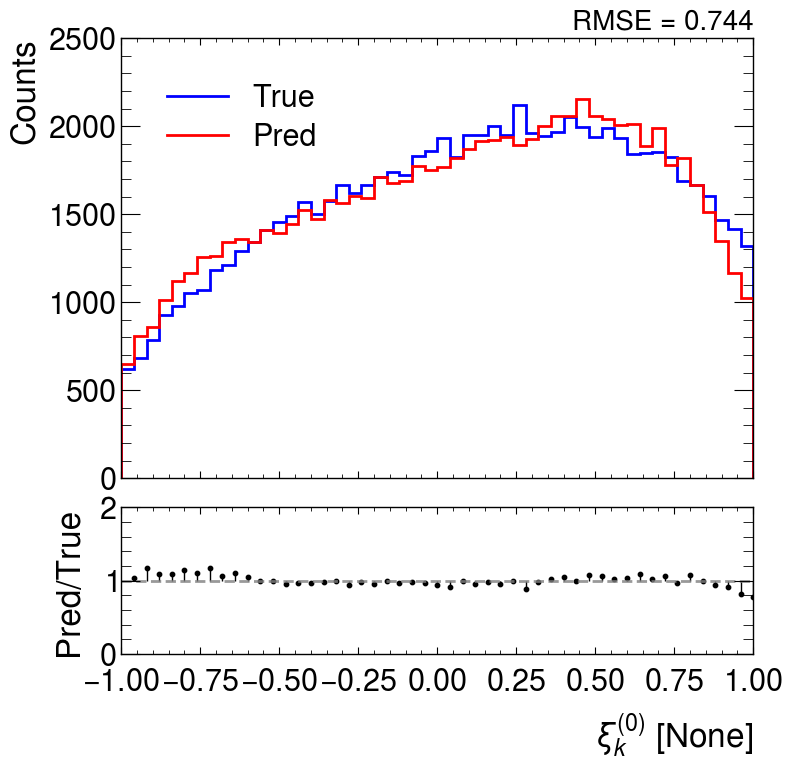

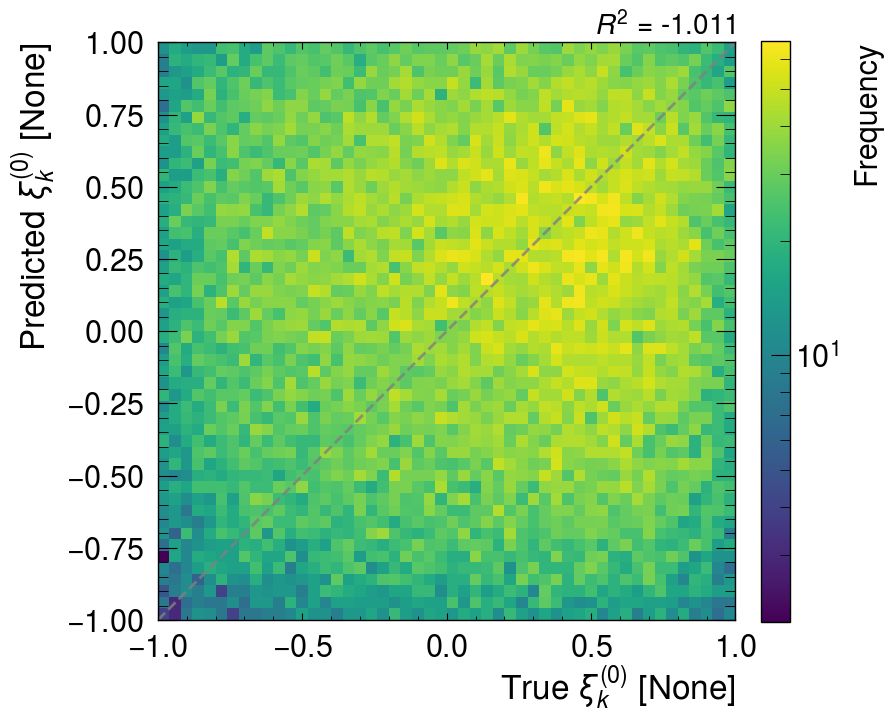

In [35]:
set_range = [-1, 1]

plot.hist_1d(
    truth_xi_p[:,2], xi_p[:,2],
    title=f"RMSE = {np.sqrt(mean_squared_error(truth_xi_p[:,2], xi_p[:,2], sample_weight=None)):.3f}",
    xlabel=r"$\xi^{(0)}_{k}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_xi_p[:,2], xi_p[:,2],
    title=r"$R^{2}$ = " + f"{r2_score(truth_xi_p[:,2], xi_p[:,2]):.3f}",
    xlabel=r"True $\xi^{(0)}_{k}$ [None]",
    ylabel=r"Predicted $\xi^{(0)}_{k}$ [None]",
    xpad=0,
    ranges=set_range
)

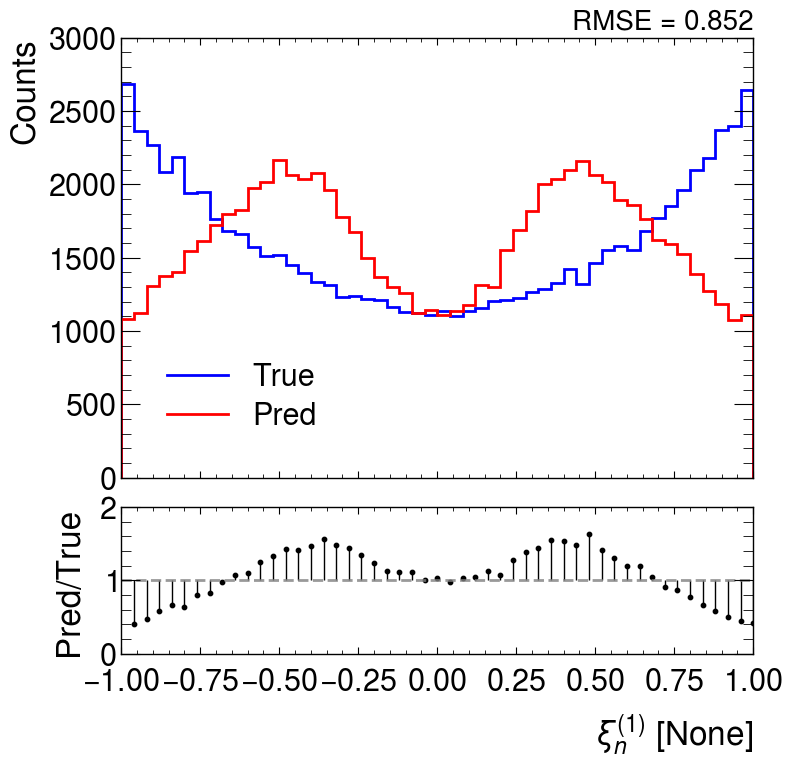

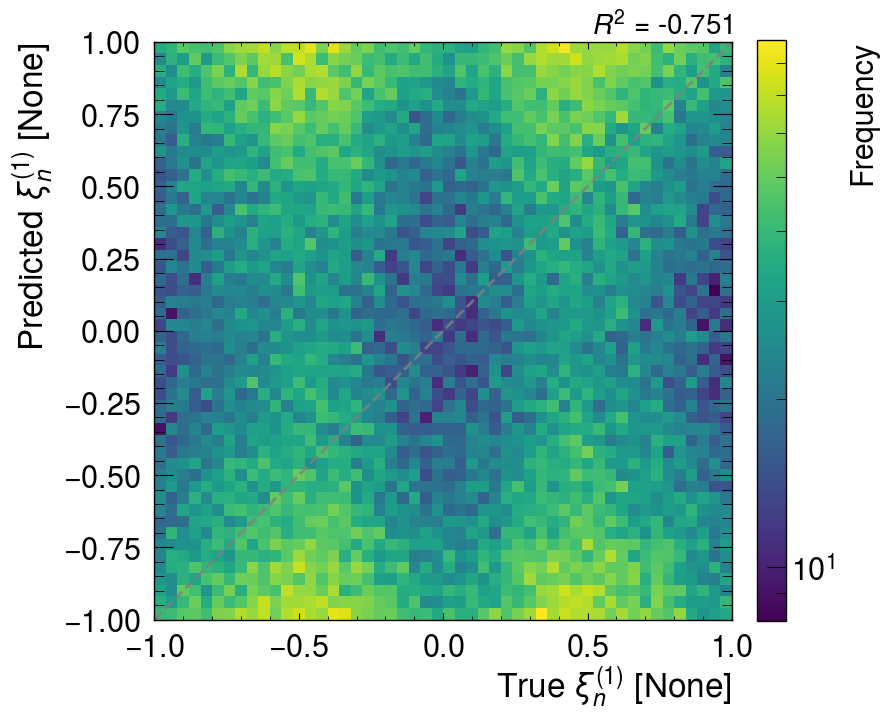

In [36]:
set_range = [-1, 1]

plot.hist_1d(
    truth_xi_n[:,0], xi_n[:,0],
    title=f"RMSE = {np.sqrt(mean_squared_error(truth_xi_n[:,0], xi_n[:,0], sample_weight=None)):.3f}",
    xlabel=r"$\xi^{(1)}_{n}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_xi_n[:,0], xi_n[:,0],
    title=r"$R^{2}$ = " + f"{r2_score(truth_xi_n[:,0], xi_n[:,0]):.3f}",
    xlabel=r"True $\xi^{(1)}_{n}$ [None]",
    ylabel=r"Predicted $\xi^{(1)}_{n}$ [None]",
    xpad=0,
    ranges=set_range
)

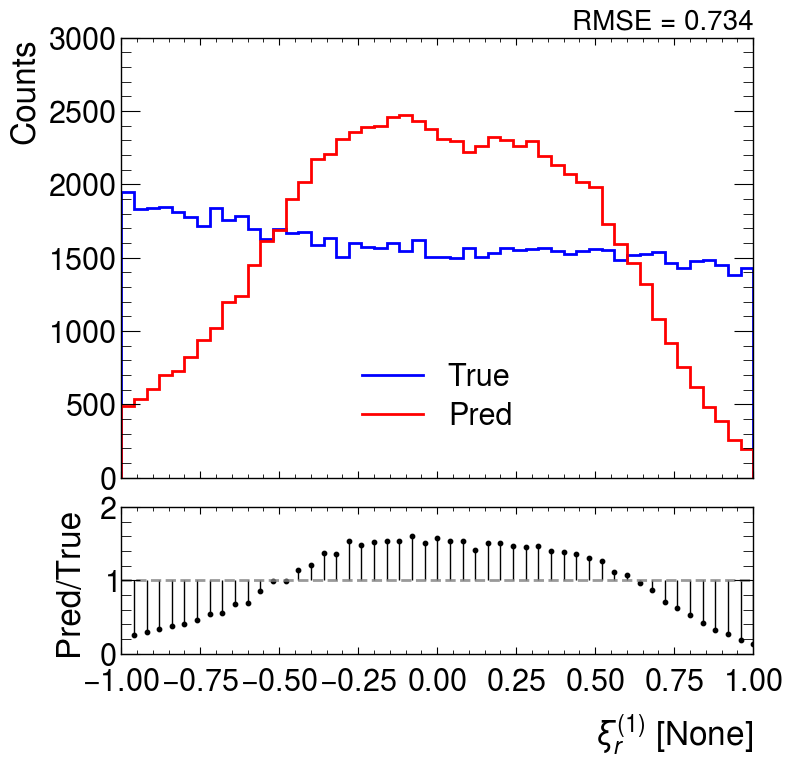

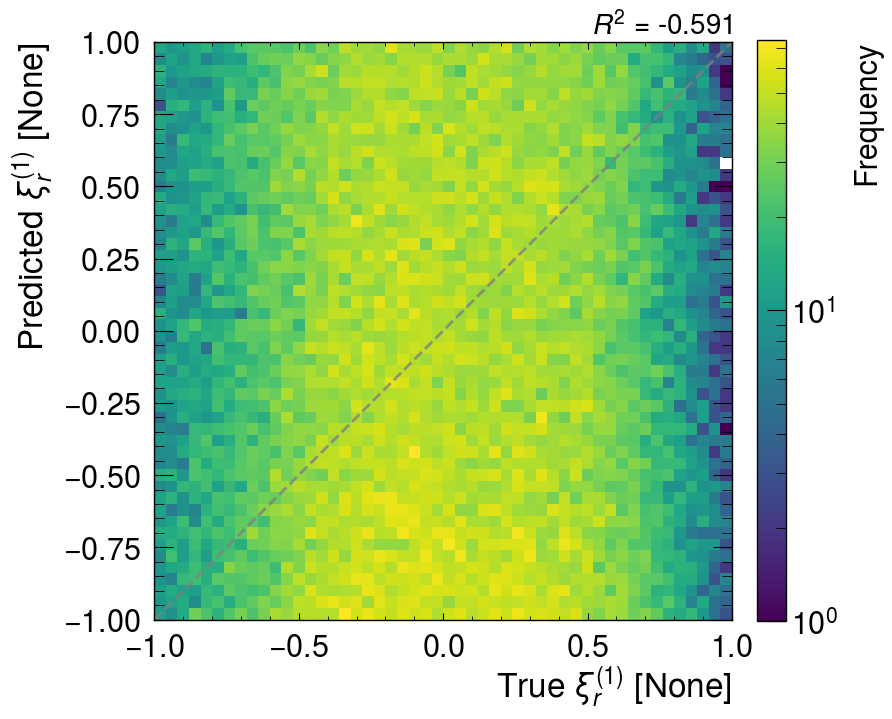

In [37]:
set_range = [-1, 1]

plot.hist_1d(
    truth_xi_n[:,1], xi_n[:,1],
    title=f"RMSE = {np.sqrt(mean_squared_error(truth_xi_n[:,1], xi_n[:,1], sample_weight=None)):.3f}",
    xlabel=r"$\xi^{(1)}_{r}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_xi_n[:,1], xi_n[:,1],
    title=r"$R^{2}$ = " + f"{r2_score(truth_xi_n[:,1], xi_n[:,1]):.3f}",
    xlabel=r"True $\xi^{(1)}_{r}$ [None]",
    ylabel=r"Predicted $\xi^{(1)}_{r}$ [None]",
    xpad=0,
    ranges=set_range
)

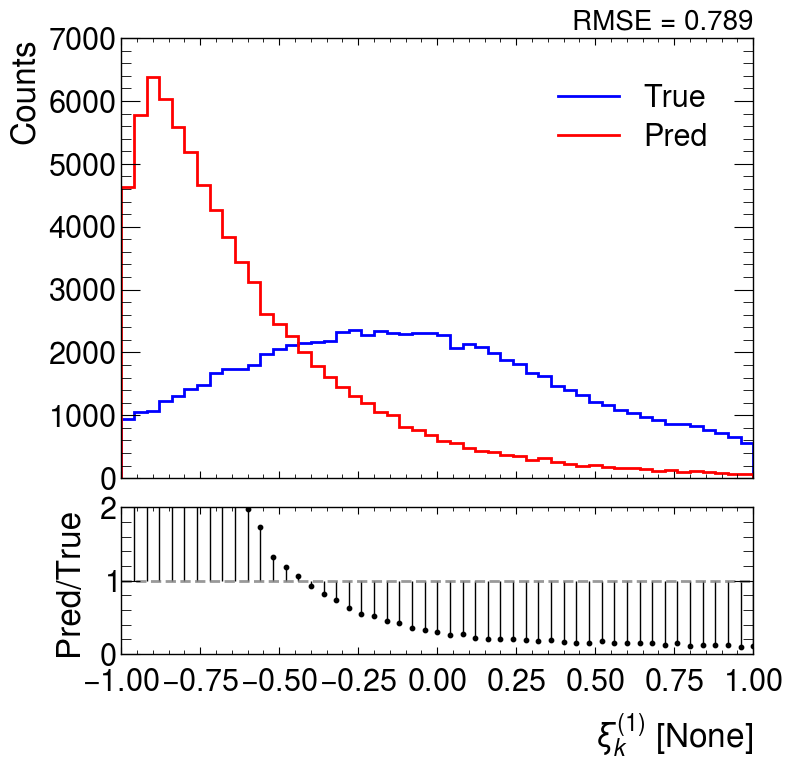

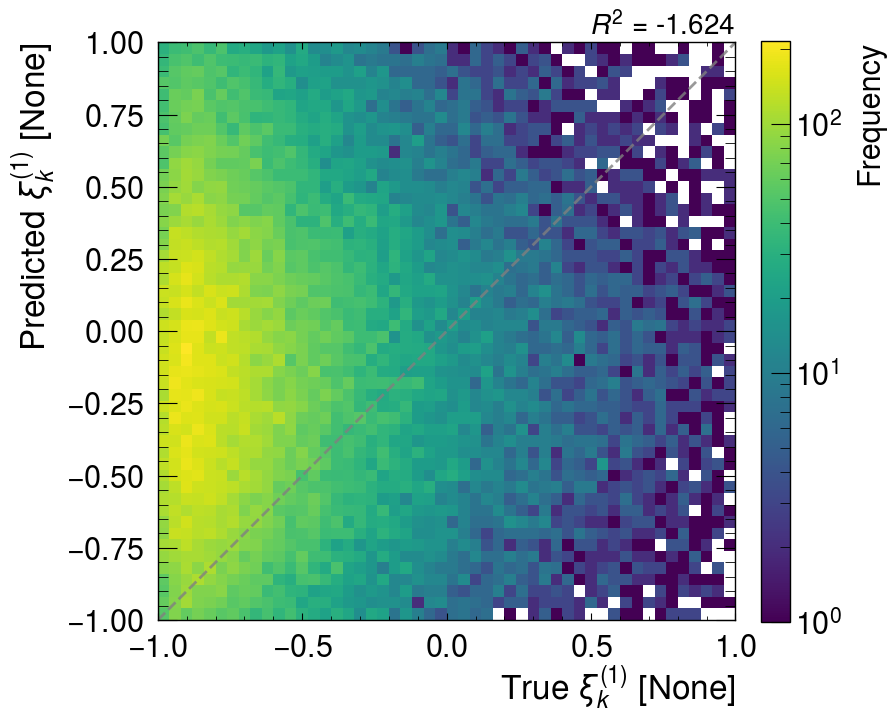

In [38]:
set_range = [-1, 1]

plot.hist_1d(
    truth_xi_n[:,2], xi_n[:,2],
    title=f"RMSE = {np.sqrt(mean_squared_error(truth_xi_n[:,2], xi_n[:,2], sample_weight=None)):.3f}",
    xlabel=r"$\xi^{(1)}_{k}$ [None]",
    ranges=set_range
)

plot.hist_2d(
    truth_xi_n[:,2], xi_n[:,2],
    title=r"$R^{2}$ = " + f"{r2_score(truth_xi_n[:,2], xi_n[:,2]):.3f}",
    xlabel=r"True $\xi^{(1)}_{k}$ [None]",
    ylabel=r"Predicted $\xi^{(1)}_{k}$ [None]",
    xpad=0,
    ranges=set_range
)

Text(0.5, 1.0, 'Predicted $WW^* p_z$ with $\\sigma=$198.17')

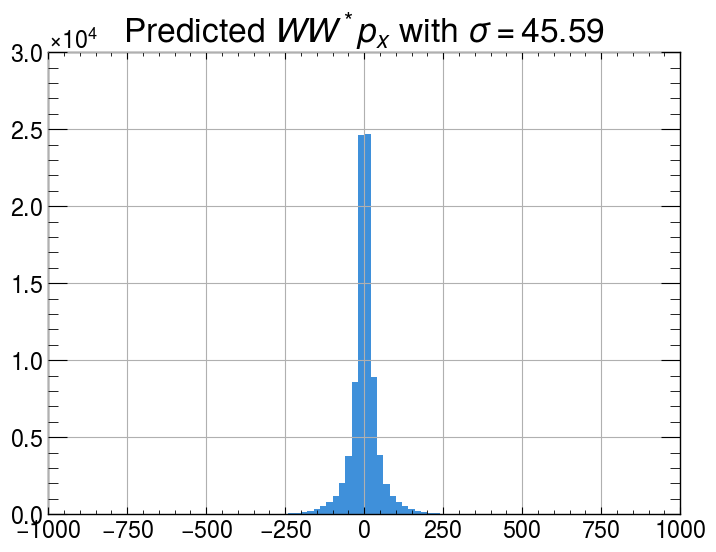

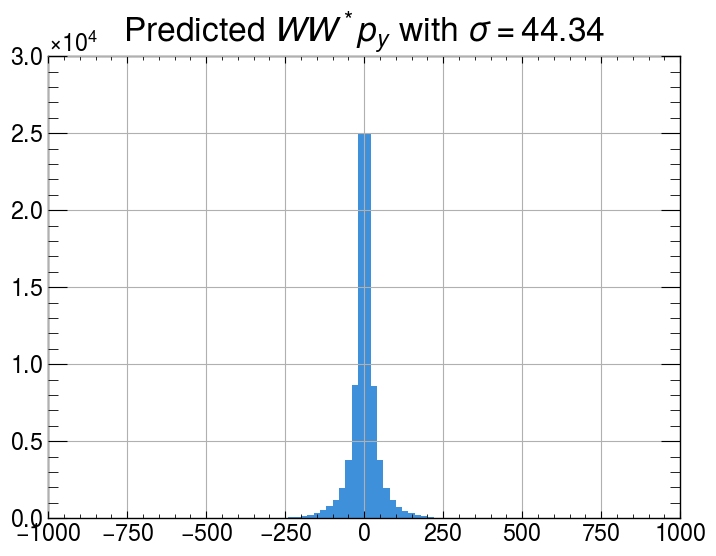

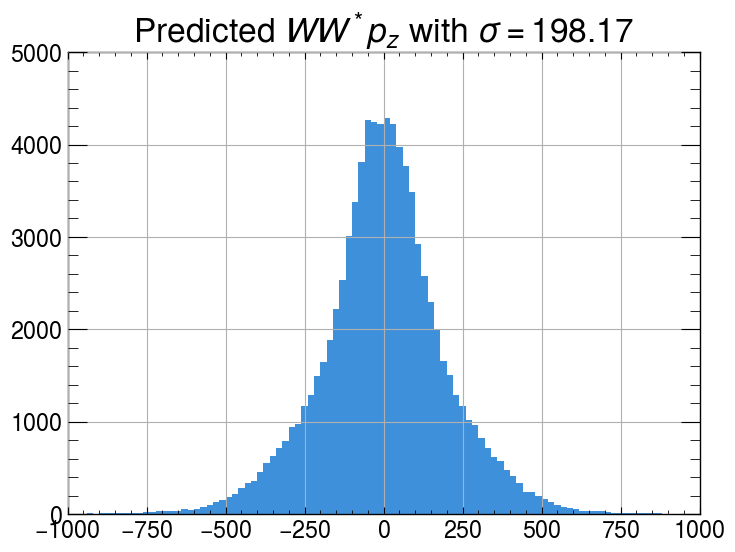

In [39]:
higgs_pred = sig_pred_inv[..., 0:4] + sig_pred_inv[..., 4:8]
bin_edges = np.linspace(-1000, 1000, 101)
higgs_pred_px = pd.DataFrame(higgs_pred[..., 0]).hist(bins=bin_edges)
higgs_pred_py = pd.DataFrame(higgs_pred[..., 1]).hist(bins=bin_edges)
higgs_pred_pz = pd.DataFrame(higgs_pred[..., 2]).hist(bins=bin_edges)
higgs_pred_px[0][0].set_title(f"Predicted $WW^* p_x$ with $\sigma=${higgs_pred[...,0].std():.2f}")
higgs_pred_py[0][0].set_title(f"Predicted $WW^* p_y$ with $\sigma=${higgs_pred[...,1].std():.2f}")
higgs_pred_pz[0][0].set_title(f"Predicted $WW^* p_z$ with $\sigma=${higgs_pred[...,2].std():.2f}")
# higgs_pred_e = pd.DataFrame(higgs_pred[..., 3]).hist()